Implemented so far: linear/tanh/ReLU activations, Gaussian/orthogonal/mixed inits, bias learning rates which can scale with depth. Works for rectangular networks where all hidden layers have the same width, but input dimension can be arbitrary. Multi-input supported for first NTK correlators with single-input NTK

To do:
- multi-input for PQ, RSTU, 4 arbitrary inputs

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import numpy as np
import torch
import torch.nn as nn
#import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import ortho_group
import gc
import pickle

In [ ]:
#Dan programmable network code


class MLP(nn.Module):
    '''
    Simple MLP with the number of layers defined programmatically.
    '''
    def __init__(self, activation, d=784, n=100, L=50, nL=10, cb=0.0, cw=1.0, weightinit='Gaussian', customweights = None, custombiases = None,
                 rescale=False, scale=1.0, power=1.0):
        '''
        activation (function) is any activation function
        d (int) is the input dimension (i.e. size of the image)
        n (int) is the width of the hidden layers
        L (int) is the number of hidden layers
        nL (int) is the width of the final layer (i.e. number of classes)
        cb (float) is the variance of the bias parameters
        cw (float) is the variance of the weight parameters
        rescale (bool) is whether preactivations and activations are rescaled
        scale (float) is if there's rescaling, the scale of the rescaling independent of depth
        power (float) is the power of the depth of the rescaling

        Todo potentially: make n, cb, cw functions of layer l.
        '''
        super(MLP, self).__init__()

        self.activation = activation
        self.cb = cb
        self.cw = cw
        self.d = d
        self.n = n
        self.L = L
        self.nL = nL
        self.rescale =rescale
        self.scale = scale
        self.power = power
        self.weightinit = weightinit

        assert self.L > 0 # at least 1 hidden layer


        # create layers
        self.fcs = list()

        # first layer is special
        fc0 = nn.Linear(self.d, self.n)
        self.fcs.append(fc0)

        # middle layers, notice the L-1
        for fci in range(L-1):
            fci = nn.Linear(self.n, self.n)
            self.fcs.append(fci)

        # last layer is special
        fcL = nn.Linear(self.n, self.nL)
        self.fcs.append(fcL)

        # register and initialize
        for i, fc in enumerate(self.fcs):
            if self.weightinit == 'mixed0':
              self.weightinit = 'Gaussian' #initializes first layer to Gaussian
              self._initialize_fc(fc)
              self.add_module('fc%d' % i, fc)
              self.weightinit = 'orthogonal' #changes to orthogonal for remaining layers
            elif self.weightinit == 'custom':
              fc.bias = torch.nn.Parameter(custombiases[i])
              fc.weight = torch.nn.Parameter(customweights[i])
              self.add_module('fc%d' % i, fc)
            else:
              self._initialize_fc(fc)
              self.add_module('fc%d' % i, fc)

    def forward(self, x):
        zs = list()
        a = x
        zs.append(x)
        for i in range(len(self.fcs)-1):
            fc = self.fcs[i]
            z = fc(a)
            zs.append(z)
            if self.rescale:
                lambda_i = self.scale*(i+1)**(-self.power)
                a = self.activation(lambda_i*z)/lambda_i
            else:
                a = self.activation(z)
        z = self.fcs[self.L](a) # last one doesn't have activation
        zs.append(z)
        return z, zs

    def _initialize_fc(self, fc):
        '''
        Initializes `fc` layer with cb and cw.
        '''
        with torch.no_grad():
            bs = fc.bias.size()
            b = torch.randn(bs)*(self.cb)**(1/2)
            if self.weightinit == 'orthogonal': #NOTE!!! This only works for rectangular networks for the time being with all layers equal
              ws = fc.weight.size()[0]
              w = torch.tensor(np.sqrt(self.cw)*ortho_group.rvs(ws),dtype=torch.float32)
            elif self.weightinit == 'Gaussian':
              ws = fc.weight.size()
              w = torch.randn(ws)*(self.cw/ws[1])**(1/2)
            else:
              raise Exception("Unsupported choice of inits")
            fc.bias = torch.nn.Parameter(b)
            fc.weight = torch.nn.Parameter(w)

def dact(act,x): #this is a hack, surely it's possible to get this with autodiff
  if act == 'ReLU':
    return torch.heaviside(x,values=torch.tensor([0.]))
  elif act == 'tanh':
    return torch.tensor(np.cosh(x.detach().numpy())**-2)
  elif act == 'linear':
    return torch.ones(x.shape)
  else:
    raise Exception("Unsupported choice of activation")

def ddact(act,x): #this is a hack, surely it's possible to get this with autodiff
  if act == 'ReLU':
    return torch.zeros(x.shape) #strictly speaking there is a delta function at zero, but all second derivative correlators end up vanishing for ReLU
  elif act == 'tanh':
    return torch.tensor(-2*(np.cosh(x.detach().numpy())**-2)*np.tanh(x.detach().numpy()))
  elif act == 'linear':
    return torch.zeros(x.shape)
  else:
    raise Exception("Unsupported choice of activation")

def d3act(act,x): #only works for smooth activation functions
  if act == 'tanh':
    return torch.tensor(-2*(np.cosh(x.detach().numpy())**-4) + 4*(np.cosh(x.detach().numpy())**-2)*(np.tanh(x.detach().numpy())**2))
  elif act == 'linear':
    return torch.zeros(x.shape)
  else:
    raise Exception("Unsupported choice of activation")

In [ ]:
#theoretical values for correlators
def ThetaReLU(l, lambdab = 1., lambdaW = 1., Kstar = 2.):
  A2 = 0.5
  return l*(lambdab + lambdaW*A2*Kstar)
def VReLU(l, Kstar = 2.):
  A2 = 0.5
  A4 = 0.5
  return (l-1)*(3*A4/(A2**2)-1)*(Kstar**2)
def BReLU(l, lambdab = 1., lambdaW = 1., Kstar = 2.):
  A2 = 0.5
  A4 = 0.5
  return (l*(l-1)*(2*l-1)/6)*(A4/(A2**2))*(lambdab + lambdaW*A2*Kstar)**2
def DReLU(l, lambdab = 1., lambdaW = 1., Kstar = 2.):
  A2 = 0.5
  A4 = 0.5
  return (l*(l-1)/2)*(lambdab*(A4/(A2**2)-1)*Kstar + lambdaW*A2*(4*A4/(A2**2) - 2)*Kstar**2)
def AReLU(l, lambdab = 1., lambdaW = 1., Kstar = 2.): #the recursion is god-awful so this just solves the recursion, which requires V, Theta, and D
  A2 = 0.5
  A4 = 0.5
  As = np.zeros(l+1)
  if l == 0: return 0
  else:
    As[1] = 0
    for i in range(1,l):
      As[i+1] = As[i] + (lambdaW*A2)**2*((3*A4/(A2**2)-1)*(Kstar**2) + VReLU(i, Kstar)) \
      + 2*lambdaW*A2*(A4/(A2**2)-1)*Kstar*ThetaReLU(i, lambdab, lambdaW, Kstar) + 2*lambdaW*A2*DReLU(i, lambdab, lambdaW, Kstar) \
      + (A4/(A2**2)-1)*(ThetaReLU(i, lambdab, lambdaW, Kstar)**2)
    return As[l]
def FReLU(l, lambdab = 1., lambdaW = 1., Kstar = 2.):
  A2 = 0.5
  A4 = 0.5
  return (l*(l-1)/2)*(A4/(A2**2))*(lambdab + lambdaW*A2*Kstar)*Kstar
def PReLU(l, lambdab = 1., lambdaW = 1., Kstar = 2.):
  return 0
def QReLU(l, lambdab = 1., lambdaW = 1., Kstar = 2.):
  A2 = 0.5
  A4 = 0.5
  return (l*(l**2 - 1)/6)*((A4/A2)*(lambdab + lambdaW*A2*Kstar)*lambdaW*Kstar)

#Linear
def ThetaLinear(l, lambdab = 1., lambdaW = 1., Kstar = 2.):
    A2 = 1
    return l*(lambdab + lambdaW*A2*Kstar)
def VLinear(l, Kstar = 2.):
    A2 = 1
    A4 = 1
    return (l-1)*(3*A4/(A2**2)-1)*(Kstar**2)
def BLinear(l, lambdab = 1., lambdaW = 1., Kstar = 2.):
    A2 = 1
    A4 = 1
    return (l*(l-1)*(2*l-1)/6)*(A4/(A2**2))*(lambdab + lambdaW*A2*Kstar)**2
def DLinear(l, lambdab = 1., lambdaW = 1., Kstar = 2.):
    A2 = 1
    A4 = 1
    return (l*(l-1)/2)*(lambdab*(A4/(A2**2)-1)*Kstar + lambdaW*A2*(4*A4/(A2**2) - 2)*(Kstar**2))
def ALinear(l, lambdab = 1., lambdaW = 1., Kstar = 2.): #the recursion is god-awful so this just solves the recursion, which requires V, Theta, and D
    A2 = 1
    A4 = 1
    As = np.zeros(l+1)
    if l == 0: return 0
    else:
        As[1] = 0
    for i in range(1,l):
        As[i+1] = As[i] + (lambdaW*A2)**2*((3*A4/(A2**2)-1)*(Kstar**2) + VLinear(i, Kstar)) \
        + 2*lambdaW*A2*(A4/(A2**2)-1)*Kstar*ThetaLinear(i, lambdab, lambdaW, Kstar) + 2*lambdaW*A2*DLinear(i, lambdab, lambdaW, Kstar) \
        + (A4/(A2**2)-1)*(ThetaLinear(i, lambdab, lambdaW, Kstar)**2)
    return As[l]
def FLinear(l, lambdab = 1., lambdaW = 1., Kstar = 2.):
    A2 = 1
    A4 = 1
    return (l*(l-1)/2)*(A4/(A2**2))*(lambdab + lambdaW*A2*Kstar)*Kstar
def PLinear(l, lambdab = 1., lambdaW = 1., Kstar = 2.):
    return 0
def QLinear(l, lambdab = 1., lambdaW = 1., Kstar = 2.):
    A2 = 1
    A4 = 1
    return (l*(l**2 - 1)/6)*((A4/A2)*(lambdab + lambdaW*A2*Kstar)*lambdaW*Kstar)

#tanh -- assumes scaling of bias learning rates
def ThetaTanh(l, lambdab = 1., lambdaW = 1.):
    a1 = -2
    sigma1 = 1
    pperp = 1
    if l ==0 : return 0
    else:
        return (lambdab + lambdaW*(sigma1**2)/(-a1))*(l**(1-pperp))

def KTanh(l):
    a1 = -2
    if l ==0 : return 0
    else:
        return 1/(-a1)*(1/l)

def VTanh(l):
    a1 = -2
    if l ==0 : return 0
    else:
        return (2/(3*(a1**2)))*(1/l)

def ATanh(l, lambdab = 1., lambdaW = 1.):
    a1 = -2
    sigma1 = 1
    pperp = 1
    if l ==0 : return 0
    else:
        return (4/27)*(pperp*lambdab + (pperp-1)*lambdaW*(sigma1**2)/(-a1))*(l**(3-2*pperp))

def BTanh(l, lambdab = 1., lambdaW = 1.):
    a1 = -2
    sigma1 = 1
    pperp = 1
    if l ==0 : return 0
    else:
        return (1/3)*((lambdab + lambdaW*(sigma1**2)/(-a1))**2)*(l**(3-2*pperp))

def DTanh(l, lambdab = 1., lambdaW = 1.):
    a1 = -2
    sigma1 = 1
    pperp = 1
    if l ==0 : return 0
    else:
        return (-2/(9*(-a1)))*(pperp*lambdab + (pperp-1)*lambdaW*(sigma1**2)/(-a1))*(l**(1-pperp))

def FTanh(l, lambdab = 1., lambdaW = 1.):
    a1 = -2
    sigma1 = 1
    pperp = 1
    if l ==0 : return 0
    else:
        return 1/(5-pperp)*1/(-a1)*(lambdab + lambdaW*(sigma1**2)/(-a1))*(l**(1-pperp))

def PTanh(l, lambdab = 1., lambdaW = 1.):
    a1 = -2
    sigma1 = 1
    pperp = 1
    if l <2 : return 0
    else:
        return -(2-pperp)/(3*(5-pperp))*((lambdab + lambdaW*(sigma1**2)/(-a1))**2)*(l**(3-2*pperp))

def QTanh(l, lambdab = 1., lambdaW = 1.):
    a1 = -2
    sigma1 = 1
    pperp = 1
    if l <2 : return 0
    else:
        return 1/((5-pperp)**2)*(1-pperp - lambdab/(lambdab + lambdaW*sigma1**2/(-a1)))*((lambdab + lambdaW*(sigma1**2)/(-a1))**2)*(l**(3-2*pperp))

def RTanh(l, lambdab = 1., lambdaW = 1.):
    a1 = -2
    sigma1 = 1
    pperp = 1
    if l <2 : return 0
    else:
        return -(-a1)*l**2/(48)*(3*lambdab + 4*lambdaW*sigma1**2/(-a1))*(lambdab + lambdaW*sigma1**2/(-a1))**2

def STanh(l, lambdab = 1., lambdaW = 1.):
    a1 = -2
    sigma1 = 1
    pperp = 1
    if l <2 : return 0
    else:
        return l**2/(12)*((lambdab + lambdaW*sigma1**2/(-a1))**2)*(lambdaW*sigma1**2)

def TTanh(l, lambdab = 1., lambdaW = 1.):
    a1 = -2
    sigma1 = 1
    pperp = 1
    if l <2 : return 0
    else:
        return (-a1)*l**2/(32)*(lambdab + lambdaW*sigma1**2/(-a1))*lambdab**2

def UTanh(l, lambdab = 1., lambdaW = 1.):
    a1 = -2
    sigma1 = 1
    pperp = 1
    if l <2 : return 0
    else:
        return (-a1/2)*((lambdab + lambdaW*sigma1**2/(-a1))**3)

def GetTheoryVals(data, depth = 10, actkey = 'ReLU', lambdab = 1., lambdaW = 1.):
    if actkey == 'ReLU':
        Kstar = 2*np.mean(data.detach().numpy()**2) #automatically accounts for possibly different n0
        Kthy = np.array([min(l,1)*Kstar for l in range(0,depth)])
        Vthy = np.array([min(l,1)*VReLU(l,Kstar) for l in range(0,depth)])
        Thetathy = np.array([ThetaReLU(l,lambdab=lambdab,lambdaW=lambdaW,Kstar=Kstar) for l in range(0,depth)])
        Athy = np.array([AReLU(l,lambdab=lambdab,lambdaW=lambdaW,Kstar=Kstar) for l in range(0,depth)])
        Bthy = np.array([BReLU(l,lambdab=lambdab,lambdaW=lambdaW,Kstar=Kstar) for l in range(0,depth)])
        Dthy = np.array([DReLU(l,lambdab=lambdab,lambdaW=lambdaW,Kstar=Kstar) for l in range(0,depth)])
        Fthy = np.array([FReLU(l,lambdab=lambdab,lambdaW=lambdaW,Kstar=Kstar) for l in range(0,depth)])
        Pthy = np.array([PReLU(l,lambdab=lambdab,lambdaW=lambdaW,Kstar=Kstar) for l in range(0,depth)])
        Qthy = np.array([QReLU(l,lambdab=lambdab,lambdaW=lambdaW,Kstar=Kstar) for l in range(0,depth)])
        theorydict = {'K': Kthy, 'V': Vthy, 'Theta': Thetathy, 'A': Athy, 'B': Bthy, 'D': Dthy, 'F': Fthy, 'P': Pthy, 'Q': Qthy}
        return theorydict
    if actkey == 'linear':
        Kstar = np.mean(data.detach().numpy()**2) #automatically accounts for possibly different n0
        Kthy = np.array([min(l,1)*Kstar for l in range(0,depth)])
        Vthy = np.array([min(l,1)*VLinear(l,Kstar) for l in range(0,depth)])
        Thetathy = np.array([ThetaLinear(l,lambdab,lambdaW=lambdaWtilde,Kstar=Kstar) for l in range(0,depth)])
        Athy = np.array([ALinear(l,lambdab=lambdab,lambdaW=lambdaW,Kstar=Kstar) for l in range(0,depth)])
        Bthy = np.array([BLinear(l,lambdab=lambdab,lambdaW=lambdaW,Kstar=Kstar) for l in range(0,depth)])
        Dthy = np.array([DLinear(l,lambdab=lambdab,lambdaW=lambdaW,Kstar=Kstar) for l in range(0,depth)])
        Fthy = np.array([FLinear(l,lambdab=lambdab,lambdaW=lambdaW,Kstar=Kstar) for l in range(0,depth)])
        Pthy = np.array([PLinear(l,lambdab=lambdab,lambdaW=lambdaW,Kstar=Kstar) for l in range(0,depth)])
        Qthy = np.array([QLinear(l,lambdab=lambdab,lambdaW=lambdaW,Kstar=Kstar) for l in range(0,depth)])
        theorydict = {'K': Kthy, 'V': Vthy, 'Theta': Thetathy, 'A': Athy, 'B': Bthy, 'D': Dthy, 'F': Fthy, 'P': Pthy, 'Q': Qthy}
        return theorydict
    if actkey == 'tanh':
        Kthy = np.array([KTanh(l) for l in range(0,depth)])
        Vthy = np.array([VTanh(l) for l in range(0,depth)])
        Thetathy = np.array([ThetaTanh(l,lambdab=lambdab,lambdaW=lambdaW) for l in range(0,depth)])
        Athy = np.array([ATanh(l,lambdab=lambdab,lambdaW=lambdaW) for l in range(0,depth)])
        Bthy = np.array([BTanh(l,lambdab=lambdab,lambdaW=lambdaW) for l in range(0,depth)])
        Dthy = np.array([DTanh(l,lambdab=lambdab,lambdaW=lambdaW) for l in range(0,depth)])
        Fthy = np.array([FTanh(l,lambdab=lambdab,lambdaW=lambdaW) for l in range(0,depth)])
        Pthy = np.array([PTanh(l,lambdab=lambdab,lambdaW=lambdaW) for l in range(0,depth)])
        Qthy = np.array([QTanh(l,lambdab=lambdab,lambdaW=lambdaW) for l in range(0,depth)])
        Rthy = np.array([RTanh(l,lambdab=lambdab,lambdaW=lambdaW) for l in range(0,depth)])
        Sthy = np.array([STanh(l,lambdab=lambdab,lambdaW=lambdaW) for l in range(0,depth)])
        Tthy = np.array([TTanh(l,lambdab=lambdab,lambdaW=lambdaW) for l in range(0,depth)])
        Uthy = np.array([UTanh(l,lambdab=lambdab,lambdaW=lambdaW) for l in range(0,depth)])
        theorydict = {'K': Kthy, 'V': Vthy, 'Theta': Thetathy, 'A': Athy, 'B': Bthy, 'D': Dthy, 'F': Fthy, 'P': Pthy, 'Q': Qthy, 'R': Rthy,
                      'S': Sthy, 'T': Tthy, 'U': Uthy}
        return theorydict



In [ ]:
#measure various correlators -- note that R/S/T/U are measured online since they only involve ddNTK mean
# for multi-input, right now only looking at two-input alpha-alpha-beta-beta structure and single-input NTK

def MeasureK(zs,zs2=None):
  zsnp=zs.detach().numpy()
  nl = zs.shape[2]
  if zs2 is None:
    Kmeas = np.mean(np.mean(zsnp**2,axis=2),axis=0)
  else:
    zs2np=zs2.detach().numpy()
    Kmeas = np.mean((1/nl)*np.einsum('ijk,ijk->ij',zsnp,zs2np),axis=0)
  Kmeas[0] = 0 #could set this to Kstar but zeroth layer stuff is just placeholder for everything else
  return Kmeas

def MeasureV(zs,zs2=None):
  zsnp=zs.detach().numpy()
  nl = zs.shape[2]
  if zs2 is None:
    K = MeasureK(zs)
    Vmeas = nl/(nl*(nl-1)/2)*sum(np.mean((zsnp[:,:,i[0]]**2)*(zsnp[:,:,i[1]]**2),axis=0) - K**2 for i in combinations(range(nl),2))
  else:
    zs2np=zs2.detach().numpy()
    K1 = MeasureK(zs)
    K2 = MeasureK(zs2)
    Vmeas = nl/(nl*(nl-1)/2)*sum(np.mean((zsnp[:,:,i[0]]**2)*(zs2np[:,:,i[1]]**2),axis=0) - K1*K2 for i in combinations(range(nl),2))
  Vmeas[0] = 0
  return Vmeas

def MeasureV6(zs):
  zsnp=zs.detach().numpy()
  nl = zs.shape[2]
  K = MeasureK(zs)
  Ez4 = 1/(nl*(nl-1)/2)*sum(np.mean((zsnp[:,:,i[0]]**2)*(zsnp[:,:,i[1]]**2),axis=0) for i in combinations(range(nl),2))
  V6meas = nl**2/(nl*(nl-1)*(nl-2)/6)*sum(np.mean((zsnp[:,:,i[0]]**2)*(zsnp[:,:,i[1]]**2)*(zsnp[:,:,i[2]]**2),axis=0) - 3*K*Ez4 + 2*K**3 for i in combinations(range(nl),3))
  V6meas[0] = 0
  return V6meas

def MeasureTheta(Hhats):
  nl = Hhats.shape[2]
  return (1/nl)*np.mean(np.trace(Hhats.detach().numpy(),axis1=2,axis2=3),axis=0)

def MeasureA(Hhats,Hhats2=None):
    DeltaHhats= Hhats.detach().numpy() - np.mean(Hhats.detach().numpy(), axis=0)
    nl = Hhats.shape[2]
    if Hhats2 is None:
      Ameas = nl/(nl*(nl-1)/2)*sum(np.mean(DeltaHhats[:,:,i[0],i[0]]*DeltaHhats[:,:,i[1],i[1]],axis=0) for i in combinations(range(nl),2))
    else:
      DeltaHhats2= Hhats2.detach().numpy() - np.mean(Hhats2.detach().numpy(), axis=0)
      Ameas = nl/(nl*(nl-1)/2)*sum(np.mean(DeltaHhats[:,:,i[0],i[0]]*DeltaHhats2[:,:,i[1],i[1]],axis=0) for i in combinations(range(nl),2))
    return Ameas

def MeasureB(Hhats, Hhats2=None):
    DeltaHhats= Hhats.detach().numpy() - np.mean(Hhats.detach().numpy(), axis=0)
    nl = Hhats.shape[2]
    if Hhats2 is None:
      Bmeas1 = nl/(nl*(nl-1)/2)*sum(np.mean(DeltaHhats[:,:,i[0],i[1]]*DeltaHhats[:,:,i[0],i[1]],axis=0) for i in combinations(range(nl),2))
      Bmeas2 = nl/(nl*(nl-1)/2)*sum(np.mean(DeltaHhats[:,:,i[0],i[1]]*DeltaHhats[:,:,i[1],i[0]],axis=0) for i in combinations(range(nl),2))
    #these should be equal, can return both values to check
    else:
      DeltaHhats2= Hhats2.detach().numpy() - np.mean(Hhats2.detach().numpy(), axis=0)
      Bmeas1 = nl/(nl*(nl-1)/2)*sum(np.mean(DeltaHhats[:,:,i[0],i[1]]*DeltaHhats2[:,:,i[0],i[1]],axis=0) for i in combinations(range(nl),2))
      Bmeas2 = nl/(nl*(nl-1)/2)*sum(np.mean(DeltaHhats[:,:,i[0],i[1]]*DeltaHhats2[:,:,i[1],i[0]],axis=0) for i in combinations(range(nl),2))
    return Bmeas1

def MeasureD(zs,Hhats):
  DeltaHhats= Hhats.detach().numpy() - np.mean(Hhats.detach().numpy(), axis=0)
  zsnp=zs.detach().numpy()
  nl = Hhats.shape[2]
  Dmeas=nl/(nl*(nl-1)/2)*sum(np.mean((zsnp[:,:,i[0]]**2)*DeltaHhats[:,:,i[1],i[1]],axis=0) for i in combinations(range(nl),2))
  return Dmeas

def MeasureF(zs,Hhats):
  DeltaHhats= Hhats.detach().numpy() - np.mean(Hhats.detach().numpy(), axis=0)
  zsnp=zs.detach().numpy()
  nl = Hhats.shape[2]
  F1meas=nl/(nl*(nl-1)/2)*sum(np.mean(zsnp[:,:,i[0]]*zsnp[:,:,i[1]]*DeltaHhats[:,:,i[0],i[1]],axis=0) for i in combinations(range(nl),2))
  F2meas=nl/(nl*(nl-1)/2)*sum(np.mean(zsnp[:,:,i[0]]*zsnp[:,:,i[1]]*DeltaHhats[:,:,i[1],i[0]],axis=0) for i in combinations(range(nl),2))
  #these should be equal, can return both values to check
  return F1meas

def MeasureP(zs,dHhats):
  zsnp=zs.detach().numpy()
  nl = zsnp.shape[2]
  dHhatsnp = dHhats.detach().numpy()
  Pmeas = nl/(nl*(nl-1)/2)*sum(np.mean(dHhatsnp[:,:,i[0],i[1],i[1]]*zsnp[:,:,i[0]],axis=0) for i in combinations(range(nl),2))
  return Pmeas

def MeasureQ(zs,dHhats):
  zsnp=zs.detach().numpy()
  nl = zsnp.shape[2]
  dHhatsnp = dHhats.detach().numpy()
  Q1meas = nl/(nl*(nl-1)/2)*sum(np.mean(dHhatsnp[:,:,i[0],i[0],i[1]]*zsnp[:,:,i[1]],axis=0) for i in combinations(range(nl),2))
  Q2meas = nl/(nl*(nl-1)/2)*sum(np.mean(dHhatsnp[:,:,i[0],i[1],i[0]]*zsnp[:,:,i[1]],axis=0) for i in combinations(range(nl),2))
  #these should be equal, can return both values to check
  return Q1meas

In [ ]:
def CollectAllCorrelators(data,data2=None,NSample=1000,depth=10,width=30,inputwidth=30,init='Gaussian',actkey='tanh',
                          lambdabtilde=1.0,lambdaWtilde=1.0,measurePQ=False,measureRSTU=False):

  Cb = 0 #all activations have Cb = 0 for criticality
  if actkey == 'tanh':
    if init =='Gaussian':
      CW = 1.0 + 2/(3*width) # NLO tuning
    else:
      CW = 1.0 # NLO tuning vanishes for orthogonal. Maybe do something clever for mixed inits?
    act = torch.tanh
  elif actkey == 'linear':
    CW = 1.0 # NLO tuning vanishes for scale-invariant
    act = lambda x: x
  elif actkey == 'ReLU':
    CW = 2.0 # NLO tuning vanishes for scale-invariant
    act = nn.ReLU()
  else:
    raise Exception("Unsupported choice of activation")

  if actkey == 'tanh':  #bias learning rate is an array that takes into account depth rescaling as appropriate
    lambdab_arr = lambdabtilde*np.array([1/max(l,1) for l in range(0,depth)])
  else:
    lambdab_arr = lambdabtilde*np.ones(depth)

  #initialize all arrays for measurement
  zs=torch.zeros((NSample,depth, width)) #NOTE! zeroth entry is a DUMMY ENTRY ONLY because input width might be different
  Hhats=torch.zeros((NSample,depth,width,width)) #NOTE! zeroth entry is a DUMMY ENTRY ONLY because input width might be different
  if data2 is not None:
    zs2 = torch.zeros((NSample,depth, width))
    Hhats2= torch.zeros((NSample,depth,width,width))
  if measurePQ:
    dHhats = torch.zeros((NSample,depth,width,width,width)) #this is the limiting factor for memory!
  if measureRSTU:
    Rmeas = np.zeros(depth)
#    Rmeas2 = np.zeros(depth)
#    Rmeas3 = np.zeros(depth)
    Smeas = np.zeros(depth)
    Tmeas = np.zeros(depth)
    Umeas = np.zeros(depth)

  #auxiliary stuff we don't need to store
  sigmas=torch.zeros((depth,width))
  sigmaprs=torch.zeros((depth,width))
  if data2 is not None:
    sigmas2 = torch.zeros((depth,width))
    sigmaprs2 = torch.zeros((depth,width))
  sigmapprs=torch.zeros((depth,width))
  sigma3prs=torch.zeros((depth,width))

  for sample in range(NSample):
  #  if sample % 2 ==0: print(sample)
    mynet=MLP(activation=act,d=data.shape[0],n=width,nL=width,L=depth,cw=CW,weightinit=init)

    #initialize dictionary to call network layers
    layerdict_ = {}
    for i, fc in enumerate(mynet.fcs):
      layerdict_['layer%s' % i]  = fc #NOTE! layer fcl contains W^(l+1)
    _, zlist = mynet.forward(data)
    if data2 is not None:
      _, zlist2 = mynet.forward(data2)

    #get preactivations and activations/derivatives
    for l in range(1,depth): #leave everything at layer zero as zero
      zs[sample,l] = zlist[l]
      sigmas[l] = act(zs[sample,l])
      sigmaprs[l] = dact(actkey,zs[sample,l])
      if data2 is not None:
        zs2[sample,l] = zlist2[l]
        sigmas2[l] = act(zs2[sample,l])
        sigmaprs2[l] = dact(actkey,zs2[sample,l])
      if measurePQ:
        sigmapprs[l] = ddact(actkey,zs[sample,l])
      if measureRSTU:
        sigma3prs[l] = d3act(actkey,zs[sample,l])

    #initial conditions for H recursion at layer 1 (8.23)
    Hhats[sample,1] = torch.eye(width)*(lambdab_arr[1] + (lambdaWtilde/inputwidth)*torch.sum(data**2)) #note that normalization is by inputwidth
    if data2 is not None:
      Hhats2[sample,1] = torch.eye(width)*(lambdab_arr[1] + (lambdaWtilde/inputwidth)*torch.sum(data2**2))
    #initial conditions for dH, ddH at layer 1 (it vanishes): automatically satisfied by initialization of dHhat and ddH_I, ddH_II arrays

    if measureRSTU:
      ddH_I = torch.zeros(width,width,width,width) #can compute ddNTK means on the fly so don't need NSample dimension
      ddH_II = torch.zeros(width,width,width,width)

    #compute H forward equation (8.12) and dH forward equation (11.24)
    for l in range(1,depth-1):
      Ws = layerdict_['layer%s' % l].weight
      Hhats[sample,l+1] = torch.eye(width)*(lambdab_arr[l+1] + (lambdaWtilde/width)*torch.sum(sigmas[l]**2)) + torch.einsum('aj,bk,j,k,jk->ab',Ws,Ws,sigmaprs[l],sigmaprs[l],Hhats[sample,l])
      if data2 is not None:
        Hhats2[sample,l+1] = torch.eye(width)*(lambdab_arr[l+1] + (lambdaWtilde/width)*torch.sum(sigmas2[l]**2)) + torch.einsum('aj,bk,j,k,jk->ab',Ws,Ws,sigmaprs2[l],sigmaprs2[l],Hhats2[sample,l])
      if measurePQ:
      #index labeling for einsum: (i0 i1 i2) = (abc), (k0 k1 k2) = (klm)
        dHhats[sample,l+1] = (lambdaWtilde/width)*(torch.einsum('ab,cm,k,k,m,km->abc',torch.eye(width),Ws,sigmaprs[l],sigmas[l],sigmaprs[l],Hhats[sample,l]) +\
                                                  torch.einsum('ac,bl,k,l,k,kl->abc',torch.eye(width),Ws,sigmaprs[l],sigmas[l],sigmaprs[l],Hhats[sample,l])) +\
                          torch.einsum('ak,bl,cm,k,l,m,klm->abc',Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],dHhats[sample,l]) +\
                          torch.einsum('ak,bl,cm,k,l,m,kl,km->abc',Ws,Ws,Ws,sigmapprs[l],sigmaprs[l],sigmaprs[l],Hhats[sample,l],Hhats[sample,l])

      if measureRSTU:
      #still inside l loop
      # width*E[ddH_I] with 2 pairs of indices equal is R
      #index labeling for einsum: (i0 i1 i2 i3) = (abcd), (j0 j1 j2 j3) = (jklm), in first 3 terms use delta to eliminate a

        deltaterm = (lambdaWtilde/width)*(torch.einsum('ab,cl,dm,k,l,m,k,kl,km->abcd',torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],Hhats[sample,l],Hhats[sample,l]) +\
                                        torch.einsum('ab,cl,dm,k,l,m,k,klm->abcd',torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],dHhats[sample,l]) +\
                                        torch.einsum('ac,dm,bk,l,m,k,l,lm,lk->abcd',torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],Hhats[sample,l],Hhats[sample,l]) +\
                                        torch.einsum('ac,dm,bk,l,m,k,l,lmk->abcd',torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],dHhats[sample,l]) +\
                                        torch.einsum('ad,bk,cl,m,k,l,m,mk,ml->abcd',torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],Hhats[sample,l],Hhats[sample,l]) +\
                                        torch.einsum('ad,bk,cl,m,k,l,m,mkl->abcd',torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],dHhats[sample,l]))

        ddHterm = torch.einsum('aj,bk,cl,dm,k,l,m,j,jklm->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],ddH_I) +\
                  torch.einsum('aj,bk,cl,dm,k,l,m,j,jkl,jm->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],dHhats[sample,l],Hhats[sample,l]) +\
                  torch.einsum('aj,bk,cl,dm,k,l,m,j,jlm,jk->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],dHhats[sample,l],Hhats[sample,l]) +\
                  torch.einsum('aj,bk,cl,dm,k,l,m,j,jmk,jl->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],dHhats[sample,l],Hhats[sample,l]) +\
                  torch.einsum('aj,bk,cl,dm,k,l,m,j,jk,jl,jm->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigma3prs[l],Hhats[sample,l],Hhats[sample,l],Hhats[sample,l])
        ddH_I = deltaterm + ddHterm #this is now ddH_I at layer l+1

        #now compute expectations
        Rmeas[l+1] += (1/NSample)*width/(width*(width-1)/2)*sum(ddH_I[i[0],i[0],i[1],i[1]] for i in combinations(range(width),2)).detach().numpy()
  #      Rmeas2[l+1] += (1/NSample)*width/(width*(width-1)/2)*sum(ddH_I[i[0],i[1],i[0],i[1]] for i in combinations(range(width),2)).detach().numpy() #only need these to check
  #      Rmeas3[l+1] += (1/NSample)*width/(width*(width-1)/2)*sum(ddH_I[i[0],i[1],i[1],i[0]] for i in combinations(range(width),2)).detach().numpy()  #only need these to check

      #index labeling for einsum: (i1 i2 i3 i4) = (abcd), (j1 j2 j3 j4) = (jklm)
        ddH_II = ((lambdaWtilde/width)**2)*torch.einsum('ac,bd,j,k,j,k,jk->abcd',torch.eye(width),torch.eye(width),sigmaprs[l],sigmaprs[l],sigmas[l],sigmas[l],Hhats[sample,l]) +\
                (lambdaWtilde/width)*(torch.einsum('ab,jk,cl,dm,j,k,l,m,jl,km->abcd',torch.eye(width),torch.eye(width),Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],Hhats[sample,l],Hhats[sample,l]) +\
                                      torch.einsum('ac,jl,bk,dm,l,m,j,k,kj,km->abcd',torch.eye(width),torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],Hhats[sample,l],Hhats[sample,l]) +\
                                      torch.einsum('ac,jl,bk,dm,l,m,j,k,kjm->abcd',torch.eye(width),torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],dHhats[sample,l]) +\
                                      torch.einsum('bd,km,aj,cl,m,l,k,j,jk,jl->abcd',torch.eye(width),torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],Hhats[sample,l],Hhats[sample,l]) +\
                                      torch.einsum('bd,km,aj,cl,m,l,k,j,jkl->abcd',torch.eye(width),torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],dHhats[sample,l])) +\
                torch.einsum('aj,bk,cl,dm,l,m,j,k,jklm->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],ddH_II) +\
                torch.einsum('aj,bk,cl,dm,l,m,j,k,jk,jl,km->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmapprs[l],sigmapprs[l],Hhats[sample,l],Hhats[sample,l],Hhats[sample,l]) +\
                torch.einsum('aj,bk,cl,dm,l,m,j,k,km,jkl->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],Hhats[sample,l],dHhats[sample,l]) +\
                torch.einsum('aj,bk,cl,dm,l,m,k,j,jl,kjm->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],Hhats[sample,l],dHhats[sample,l])
      #now compute expectations
        Smeas[l+1] += (1/NSample)*width/(width*(width-1)/2)*sum(ddH_II[i[0],i[0],i[1],i[1]] for i in combinations(range(width),2)).detach().numpy()
        Tmeas[l+1] += (1/NSample)*width/(width*(width-1)/2)*sum(ddH_II[i[0],i[1],i[0],i[1]] for i in combinations(range(width),2)).detach().numpy()
        Umeas[l+1] += (1/NSample)*width/(width*(width-1)/2)*sum(ddH_II[i[0],i[1],i[1],i[0]] for i in combinations(range(width),2)).detach().numpy()

  #  del mynet
    if measureRSTU:
      del deltaterm
      del ddHterm
      del ddH_I
      del ddH_II
      gc.collect()

  if measurePQ:
    if measureRSTU:
      RSTUDict={'R': Rmeas, 'S': Smeas, 'T': Tmeas, 'U': Umeas}
      return zs, Hhats, dHhats, RSTUDict
    else:
      return zs, Hhats, dHhats
  if data2 is not None:
    return zs, zs2, Hhats, Hhats2
  else:
    return zs, Hhats



## Here begins the experiment.

Largest network for measuring through P and Q: depth 8, width 75, NSample = 250

Largest (so far) for measuring RSTU: depth 11, width 50, NSample = 100 (8.5 min runtime for both Gaussian and orthogonal)

In [ ]:
#network architecture
depth = 10
width = 30
#inputwidth = 128
inputwidth = width
#random input data (single-input)
#data = torch.ones(inputwidth)
data = torch.Tensor(np.random.rand(inputwidth))

In [ ]:
print(data)

tensor([0.6870, 0.8226, 0.2951, 0.8905, 0.0606, 0.6356, 0.0887, 0.6616, 0.6878,
        0.7694, 0.5253, 0.8086, 0.7204, 0.7255, 0.3547, 0.2564, 0.6180, 0.4643,
        0.3241, 0.6816, 0.2861, 0.0785, 0.1117, 0.9877, 0.0549, 0.0063, 0.6155,
        0.9612, 0.9619, 0.6708])


In [ ]:
#set init here: 'Gaussian', 'orthogonal', or 'mixed0' currently supported
init = 'mixed0'

#set activation here
actkey = 'tanh'

#set learning rates here
lambdabtilde = 1.0
lambdaWtilde = 1.0

measurePQ = False
measureRSTU = False

NSample = 1000

In [ ]:
# zs, Hhats, dHhats, RSTUDict = CollectAllCorrelators(data,NSample=NSample,depth=depth,width=width,inputwidth=inputwidth,init=init,actkey=actkey,lambdabtilde=lambdabtilde,
#                       lambdaWtilde=lambdaWtilde,measurePQ=measurePQ,measureRSTU=measureRSTU)

zs, Hhats = CollectAllCorrelators(data,NSample=NSample,depth=depth,width=width,inputwidth=inputwidth,init=init,actkey=actkey,lambdabtilde=lambdabtilde,
                       lambdaWtilde=lambdaWtilde,measurePQ=measurePQ,measureRSTU=measureRSTU)

In [ ]:
Kmeas = MeasureK(zs)
Vmeas = MeasureV(zs)
VoverK2=Vmeas/(Kmeas**2)

<ipython-input-14-5bffd92b3efc>:3: RuntimeWarning: invalid value encountered in divide
  VoverK2=Vmeas/(Kmeas**2)


In [ ]:
print(VoverK2)

[       nan 0.15902364 0.6411989  1.0693535  1.8547701  2.720719  ]


Text(0.5, 0, 'hidden layer')

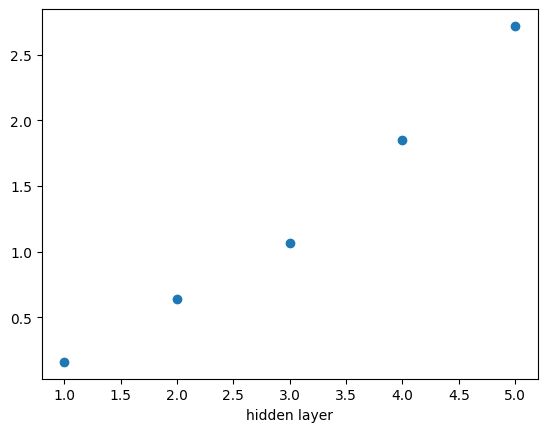

In [ ]:
plt.scatter(range(1,depth),VoverK2[1:])
#plt.scatter(range(1,depth),VmeasTanh[1:]/(KmeasTanh[1:]**2),label='tanh')
#plt.plot(range(1,depth),75*np.arange(1,depth)**2)
plt.xlabel('hidden layer')
#plt.ylabel('V6/K^3')
#plt.legend(loc='best')

In [ ]:
nL=10
n=30
m1=m2=nL/2
print((m1*m2/8)*(VoverK2[1:]/n)**2 - (m1*m2*(20+3*m1+3*m2)/48)*(VoverK2[1:]/n)**3)
print(4/(20+3*nL)*(3/2)*n)

[ 1.37395564e-05  5.51398238e-03 -1.09733231e-02 -1.08653605e-01
 -5.15109777e-01 -1.78969836e+00 -4.22813416e+00 -7.61352634e+00
 -1.35746822e+01]
3.5999999999999996


In [ ]:
nL = 10
for i in range(10):
  m1 = i
  m2 = nL-i
  print((m1*m2/8)*(VoverK2[1:]/n)**2 - (m1*m2*(20+3*m1+3*m2)/48)*(VoverK2[1:]/n)**3)

[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.0066756  0.00600635 0.00581545 0.00572067 0.00566092 0.00577603
 0.00574287 0.00589816 0.00580278]
[0.01186773 0.01067795 0.01033858 0.01017007 0.01006387 0.01026849
 0.01020954 0.01048562 0.01031606]
[0.0155764  0.01401481 0.01356939 0.01334822 0.01320882 0.0134774
 0.01340003 0.01376237 0.01353983]
[0.0178016  0.01601693 0.01550787 0.01525511 0.0150958  0.01540274
 0.01531431 0.01572843 0.01547409]
[0.01854333 0.0166843  0.01615403 0.01589074 0.01572479 0.01604452
 0.01595241 0.01638377 0.01611885]
[0.0178016  0.01601693 0.01550787 0.01525511 0.0150958  0.01540274
 0.01531431 0.01572843 0.01547409]
[0.0155764  0.01401481 0.01356939 0.01334822 0.01320882 0.0134774
 0.01340003 0.01376237 0.01353983]
[0.01186773 0.01067795 0.01033858 0.01017007 0.01006387 0.01026849
 0.01020954 0.01048562 0.01031606]
[0.0066756  0.00600635 0.00581545 0.00572067 0.00566092 0.00577603
 0.00574287 0.00589816 0.00580278]


In [ ]:
print(V6meas[1:]/Kmeas[1:]**3)
print(12*(depth/width)**3)

[-2.0425849e-01  1.0807160e+01  3.1424135e+01  9.1365982e+01
  1.8434288e+02  3.8666565e+02  5.6295294e+02  1.0257189e+03
  1.2096790e+03]
0.09600000000000003


In [ ]:
Kmeas = MeasureK(zs)
Vmeas = MeasureV(zs)
#Thetameas = MeasureTheta(Hhats)
#Ameas = MeasureA(Hhats)
#Bmeas = MeasureB(Hhats)
#Dmeas = MeasureD(zs,Hhats)
#Fmeas = MeasureF(zs,Hhats)
if measurePQ:
  Pmeas = MeasureP(zs,dHhats)
  Qmeas = MeasureQ(zs,dHhats)

print(Kmeas)
print(Vmeas)
#print(Thetameas)
#print(Ameas)
#print(Bmeas)
#print(Dmeas)
#print(Fmeas)
if measurePQ:
  print(Pmeas)
  print(Qmeas)
if measureRSTU:
  print(RSTUDict['R'])
  print(RSTUDict['S'])
  print(RSTUDict['T'])
  print(RSTUDict['U'])

[0.         0.37347305 0.22917451 0.16388771 0.12721027 0.10375277
 0.08748235 0.07545076 0.06639196 0.05921904]
[ 0.          0.01723843 -0.04953323 -0.03374029 -0.02308522 -0.01644885
 -0.01242359 -0.0093032  -0.00744004 -0.0058918 ]


In [ ]:
#save data
CorrDict = {'K':Kmeas},#'Theta':Thetameas,'A':Ameas,'B':Bmeas,'D':Dmeas,'F':Fmeas}#,'P':Pmeas,'Q':Qmeas,'R':RSTUDict['R'],'S':RSTUDict['S'],'T':RSTUDict['T'],'U':RSTUDict['U']}
with open('CorrDict_'+init+'W'+str(width)+'D'+str(depth)+'.pkl', 'wb') as file:
    pickle.dump(CorrDict, file)

In [ ]:
theorydict = GetTheoryVals(data, depth = depth, actkey = actkey,lambdab = lambdabtilde, lambdaW = lambdaWtilde)
Kthy = theorydict['K']
Vthy = theorydict['V']
#Thetathy = theorydict['Theta']
#Athy = theorydict['A']
#Bthy = theorydict['B']
#Dthy = theorydict['D']
#Fthy = theorydict['F']
if measurePQ:
  Pthy = theorydict['P']
  Qthy = theorydict['Q']
if measureRSTU:
  Rthy = theorydict['R']
  Sthy = theorydict['S']
  Tthy = theorydict['T']
  Uthy = theorydict['U']
print(theorydict)

{'K': array([0.        , 0.5       , 0.25      , 0.16666667, 0.125     ,
       0.1       , 0.08333333, 0.07142857, 0.0625    , 0.05555556]), 'V': array([0.        , 0.16666667, 0.08333333, 0.05555556, 0.04166667,
       0.03333333, 0.02777778, 0.02380952, 0.02083333, 0.01851852]), 'Theta': array([0. , 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]), 'A': array([0.        , 0.14814815, 0.2962963 , 0.44444444, 0.59259259,
       0.74074074, 0.88888889, 1.03703704, 1.18518519, 1.33333333]), 'B': array([0.  , 0.75, 1.5 , 2.25, 3.  , 3.75, 4.5 , 5.25, 6.  , 6.75]), 'D': array([ 0.        , -0.11111111, -0.11111111, -0.11111111, -0.11111111,
       -0.11111111, -0.11111111, -0.11111111, -0.11111111, -0.11111111]), 'F': array([0.    , 0.1875, 0.1875, 0.1875, 0.1875, 0.1875, 0.1875, 0.1875,
       0.1875, 0.1875]), 'P': array([ 0.    ,  0.    , -0.375 , -0.5625, -0.75  , -0.9375, -1.125 ,
       -1.3125, -1.5   , -1.6875]), 'Q': array([ 0.     ,  0.     , -0.1875 , -0.28125, -0.375  , -0.46875,

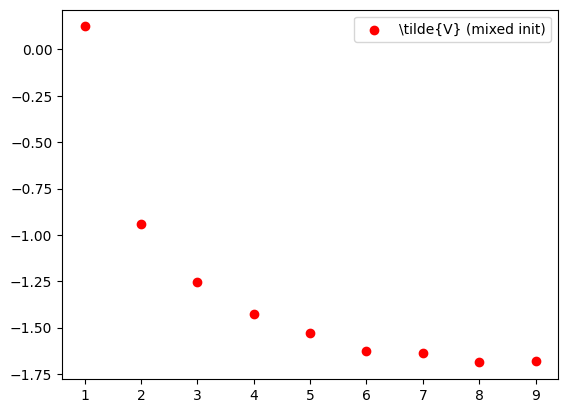

In [ ]:
plt.scatter(range(1,depth),Vmeas[1:]/(Kmeas[1:]**2),label=r'\tilde{V} (mixed init)', color='red')
plt.legend(loc='upper right')
#plt.plot(range(1,depth),Vthy[1:]/(Kthy[1:]**2), color = 'red')

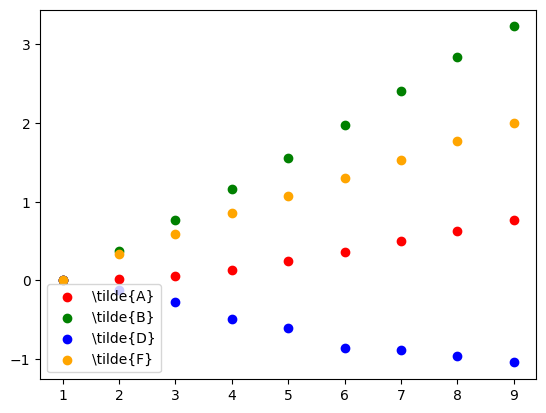

In [ ]:
plt.scatter(range(1,depth),Ameas[1:]/(Thetameas[1:]**2),label=r'\tilde{A}', color='red')
#plt.plot(range(1,depth),Athy[1:]/(Thetathy[1:]**2), color = 'red')

plt.scatter(range(1,depth),Bmeas[1:]/(Thetameas[1:]**2),label=r'\tilde{B}', color = 'green')
#plt.plot(range(1,depth),Bthy[1:]/(Thetathy[1:]**2), color = 'green')

plt.scatter(range(1,depth),Dmeas[1:]/(Thetameas[1:]*Kmeas[1:]),label=r'\tilde{D}', color = 'blue')
#plt.plot(range(1,depth),Dthy[1:]/(Thetathy[1:]*Kthy[1:]), color = 'blue')

plt.scatter(range(1,depth),Fmeas[1:]/(Thetameas[1:]*Kmeas[1:]),label=r'\tilde{F}', color = 'orange')
#plt.plot(range(1,depth),Fthy[1:]/(Thetathy[1:]*Kthy[1:]), color = 'orange')

plt.legend(loc='lower left')

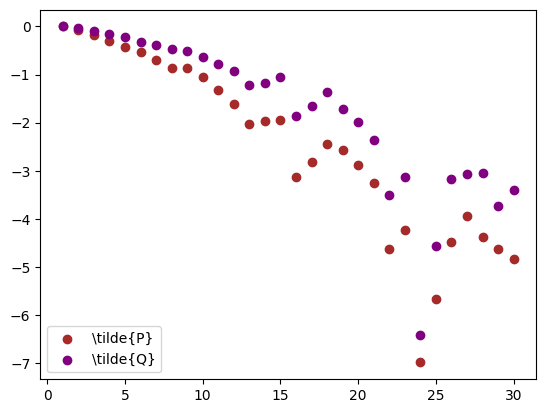

In [ ]:
plt.scatter(range(1,depth),Pmeas[1:]/(Thetameas[1:]**2),label=r'\tilde{P}', color='brown')
#plt.plot(range(1,depth),Pthy[1:]/(Thetathy[1:]**2), color='brown')

plt.scatter(range(1,depth),Qmeas[1:]/(Thetameas[1:]**2),label=r'\tilde{Q}',color='purple')
#plt.plot(range(1,depth),Qthy[1:]/(Thetathy[1:]**2),color='purple')

plt.legend(loc='lower left')

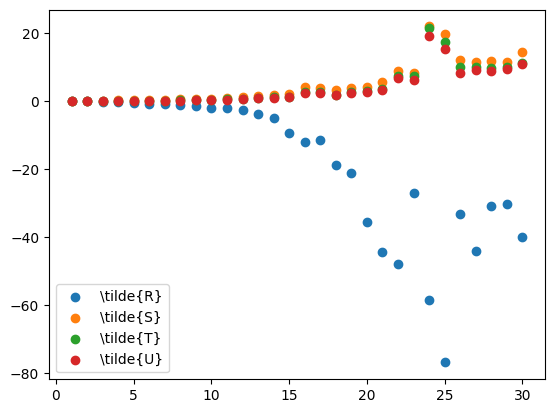

In [ ]:
plt.scatter(range(1,depth),RSTUDict['R'][1:]*Kmeas[1:]/(Thetameas[1:]**3),label=r'\tilde{R}')
#plt.plot(range(1,depth),Rthy[1:]*Kthy[1:]/(Thetathy[1:]**3))

plt.scatter(range(1,depth),RSTUDict['S'][1:]*Kmeas[1:]/(Thetameas[1:]**3),label=r'\tilde{S}')
#plt.plot(range(1,depth),Sthy[1:]*Kthy[1:]/(Thetathy[1:]**3))

plt.scatter(range(1,depth),RSTUDict['T'][1:]*Kmeas[1:]/(Thetameas[1:]**3),label=r'\tilde{T}')
#plt.plot(range(1,depth),Tthy[1:]*Kthy[1:]/(Thetathy[1:]**3))

plt.scatter(range(1,depth),RSTUDict['U'][1:]*Kmeas[1:]/(Thetameas[1:]**3),label=r'\tilde{U}')
#plt.plot(range(1,depth),Uthy[1:]*Kthy[1:]/(Thetathy[1:]**3))


plt.legend(loc='lower left')

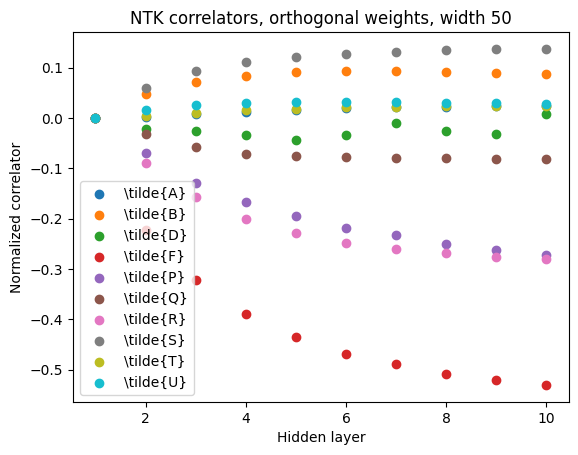

In [ ]:
#try everything on one plot

plt.scatter(range(1,depth),Ameas[1:]/(Thetameas[1:]**2),label=r'\tilde{A}')

plt.scatter(range(1,depth),Bmeas[1:]/(Thetameas[1:]**2),label=r'\tilde{B}')

plt.scatter(range(1,depth),Dmeas[1:]/(Thetameas[1:]*Kmeas[1:]),label=r'\tilde{D}')

plt.scatter(range(1,depth),Fmeas[1:]/(Thetameas[1:]*Kmeas[1:]),label=r'\tilde{F}')

plt.scatter(range(1,depth),Pmeas[1:]/(Thetameas[1:]**2),label=r'\tilde{P}')

plt.scatter(range(1,depth),Qmeas[1:]/(Thetameas[1:]**2),label=r'\tilde{Q}')

plt.scatter(range(1,depth),RSTUDict['R'][1:]*Kmeas[1:]/(Thetameas[1:]**3),label=r'\tilde{R}')

plt.scatter(range(1,depth),RSTUDict['S'][1:]*Kmeas[1:]/(Thetameas[1:]**3),label=r'\tilde{S}')

plt.scatter(range(1,depth),RSTUDict['T'][1:]*Kmeas[1:]/(Thetameas[1:]**3),label=r'\tilde{T}')

plt.scatter(range(1,depth),RSTUDict['U'][1:]*Kmeas[1:]/(Thetameas[1:]**3),label=r'\tilde{U}')

plt.title('NTK correlators, '+init+' weights, width ' +str(width))
plt.xlabel('Hidden layer')
plt.ylabel('Normalized correlator')
plt.legend(loc='lower left')

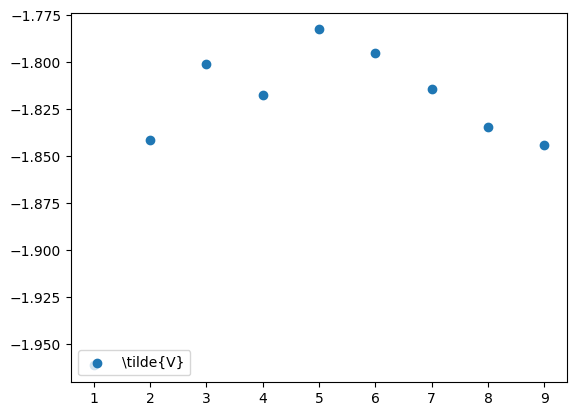

In [ ]:
plt.scatter(range(1,depth),Vmeas[1:]/(Kmeas[1:]**2),label=r'\tilde{V}')
#plt.plot(range(1,depth),Vthy[1:]/(Kthy[1:]**2))
#plt.plot(range(1,depth),[3*l-5 for l in range(1,depth)])
plt.legend(loc='lower left')

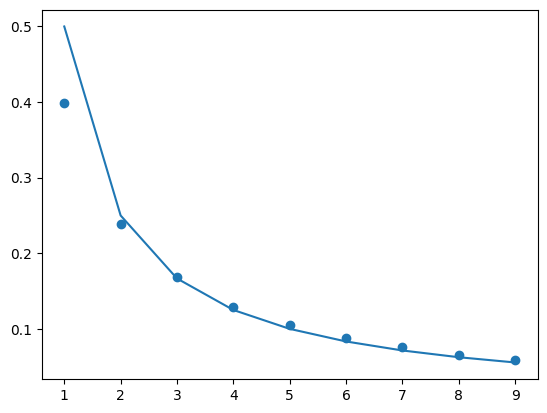

In [ ]:
plt.scatter(range(1,depth),Kmeas[1:],label=r'\tilde{K}')
plt.plot(range(1,depth),Kthy[1:])

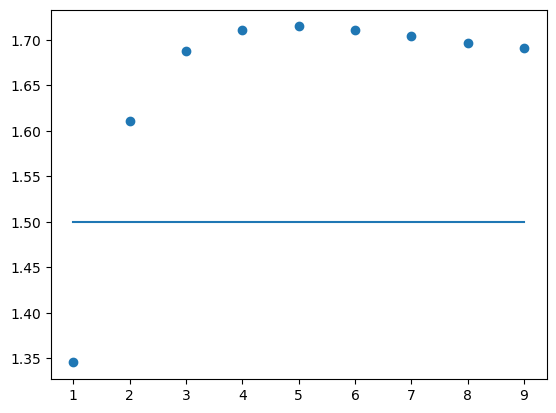

In [ ]:
plt.scatter(range(1,depth),Thetameas[1:],label=r'\tilde{Theta}')
plt.plot(range(1,depth),Thetathy[1:])

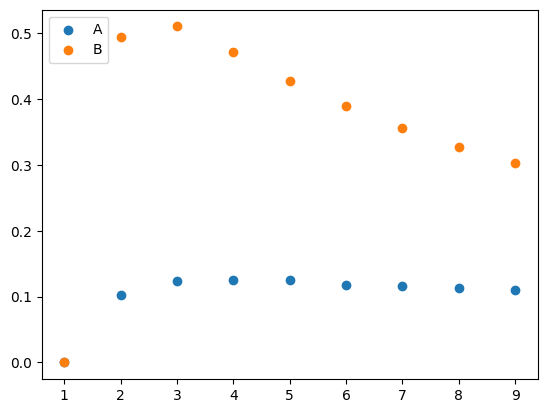

In [ ]:
plt.scatter(range(1,depth),Ameas[1:],label='A')
#plt.plot(range(1,depth),Athy[1:])

plt.scatter(range(1,depth),Bmeas[1:],label='B')
#plt.plot(range(1,depth),Bthy[1:])

plt.legend(loc = 'upper left')

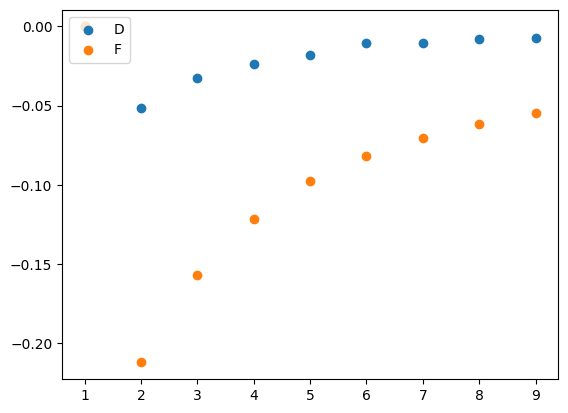

In [ ]:
plt.scatter(range(1,depth),Dmeas[1:],label='D')
#plt.plot(range(1,depth),Dthy[1:])

plt.scatter(range(1,depth),Fmeas[1:],label=r'F')
#plt.plot(range(1,depth),Fthy[1:])

plt.legend(loc='upper left')

# Multi-input measurements

In [ ]:
MNIST_loader = torch.utils.data.DataLoader(
  datasets.MNIST('/files/', train=True, download=True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=100, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 83193518.41it/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 72885495.68it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 21319878.41it/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16536917.33it/s]


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [ ]:
examples = enumerate(MNIST_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
example_data.shape

torch.Size([100, 1, 28, 28])

In [ ]:
#find all digit 1's
ones_idx=torch.where(example_targets==torch.tensor(1))
ones_data=example_data[ones_idx]

In [ ]:
ones_data.shape

torch.Size([10, 1, 28, 28])

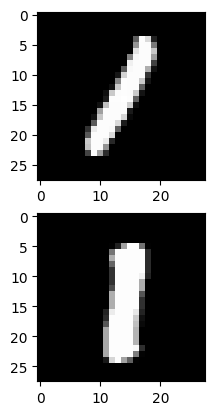

In [ ]:
plt.subplot(211)
plt.imshow(ones_data[0][0], cmap='gray', interpolation='none')
plt.subplot(212)
plt.imshow(ones_data[1][0], cmap='gray', interpolation='none')
plt.show()

In [ ]:
#network architecture
depth = 40
width = 20
#inputwidth = 784
inputwidth = width
#random input data (single-input)
#data = torch.ones(inputwidth)
#data1 = torch.flatten(ones_data[0,0,:,:])
#data2 = torch.flatten(example_data[0,0,:,:])
data1 = torch.Tensor(np.random.rand(inputwidth))
data2 = torch.Tensor(np.random.rand(inputwidth))

#set init here: 'Gaussian', 'orthogonal', or 'mixed0' currently supported
init = 'Gaussian'

#set activation here
actkey = 'ReLU'

#set learning rates here
lambdabtilde = 1.0
lambdaWtilde = 1.0

measurePQ = False
measureRSTU = False

NSample = 1000

In [ ]:
print(torch.mean(data2))
print(torch.mean(data1))

tensor(0.5229)
tensor(0.5584)


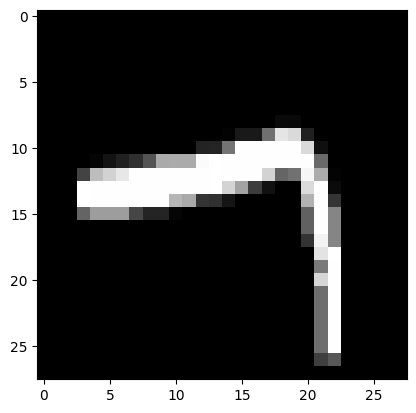

In [ ]:
plt.imshow(data2.reshape((28,28)).detach().numpy(), cmap='gray', interpolation='none')

In [ ]:
zs, zs2, Hhats, Hhats2 = CollectAllCorrelators(data1,data2=data2,NSample=NSample,depth=depth,width=width,
                                               inputwidth=inputwidth,init='Gaussian',actkey=actkey,lambdabtilde=lambdabtilde,
                      lambdaWtilde=lambdaWtilde,measurePQ=measurePQ,measureRSTU=measureRSTU)

#check Boris's angle thing
GaussAngle=np.array(MeasureK(zs,zs2=zs2)/np.sqrt(MeasureK(zs)*MeasureK(zs2)))[1:]

zs, zs2, Hhats, Hhats2 = CollectAllCorrelators(data1,data2=data2,NSample=NSample,depth=depth,width=width,
                                               inputwidth=inputwidth,init='orthogonal',actkey=actkey,lambdabtilde=lambdabtilde,
                      lambdaWtilde=lambdaWtilde,measurePQ=measurePQ,measureRSTU=measureRSTU)

OrthoAngle=np.array(MeasureK(zs,zs2=zs2)/np.sqrt(MeasureK(zs)*MeasureK(zs2)))[1:]

<ipython-input-6-28a197365bb9>:6: RuntimeWarning: invalid value encountered in divide
  GaussAngle=np.array(MeasureK(zs,zs2=zs2)/np.sqrt(MeasureK(zs)*MeasureK(zs2)))[1:]
<ipython-input-6-28a197365bb9>:12: RuntimeWarning: invalid value encountered in divide
  OrthoAngle=np.array(MeasureK(zs,zs2=zs2)/np.sqrt(MeasureK(zs)*MeasureK(zs2)))[1:]


In [ ]:
print(GaussAngle)
print(OrthoAngle)

[0.8070232  0.8281759  0.8478944  0.86609465 0.87773854 0.88509506
 0.890555   0.8994576  0.8996321  0.90349114 0.9008611  0.90642285
 0.9166574  0.9130493  0.91850847 0.9339961  0.9289503  0.9416059
 0.9298742  0.9285932  0.9269104  0.9205514  0.91601604 0.91730815
 0.9177359  0.9183524  0.9129981  0.9080806  0.9016467  0.9108435
 0.91023797 0.90088594 0.90229255 0.9033705  0.9002514  0.90615946
 0.9024213  0.8937889  0.89527196]
[0.80694014 0.8334834  0.85305274 0.8722396  0.88403493 0.8904208
 0.8996248  0.90654004 0.9146211  0.9190405  0.9230388  0.9241459
 0.9271421  0.9297718  0.9321827  0.9335987  0.9351424  0.9349807
 0.9359842  0.93677056 0.9348156  0.93767303 0.9359952  0.9379044
 0.93733835 0.94016576 0.94025964 0.94036484 0.94165    0.9417302
 0.9406366  0.9391686  0.9400038  0.9404218  0.9440219  0.9444327
 0.94533277 0.94598216 0.9453399 ]


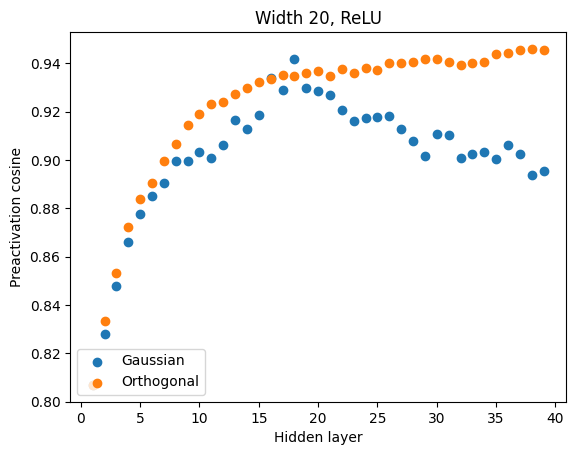

In [ ]:
plt.scatter(range(1,depth),GaussAngle,label='Gaussian')
plt.scatter(range(1,depth),OrthoAngle,label='Orthogonal')
plt.xlabel('Hidden layer')
plt.ylabel('Preactivation cosine')
plt.title('Width 20, ReLU')
plt.legend(loc='lower left')

In [ ]:
Kmeas = MeasureK(zs2)
Vmeas = MeasureV(zs2)
Thetameas = MeasureTheta(Hhats)
Ameas = MeasureA(Hhats)
Bmeas = MeasureB(Hhats)
Dmeas = MeasureD(zs,Hhats)
Fmeas = MeasureF(zs,Hhats)

theorydict = GetTheoryVals(data2, depth = depth, actkey = actkey,lambdab = lambdabtilde, lambdaW = lambdaWtilde)
Kthy = theorydict['K']
Vthy = theorydict['V']
Thetathy = theorydict['Theta']
Athy = theorydict['A']
Bthy = theorydict['B']
Dthy = theorydict['D']
Fthy = theorydict['F']

print(Kmeas)
print(Kthy)
print("")
print(Vmeas)
print(Vthy)

[0.         0.8567664  0.36924967 0.22752766 0.1630302  0.12665248
 0.10246336 0.08642127 0.07433868 0.06520667]
[0.         0.5        0.25       0.16666667 0.125      0.1
 0.08333333 0.07142857 0.0625     0.05555556]

[0.         0.12050311 0.07300383 0.0584325  0.04035662 0.03699245
 0.02766611 0.02425752 0.0224811  0.02195854]
[0.         0.16666667 0.08333333 0.05555556 0.04166667 0.03333333
 0.02777778 0.02380952 0.02083333 0.01851852]


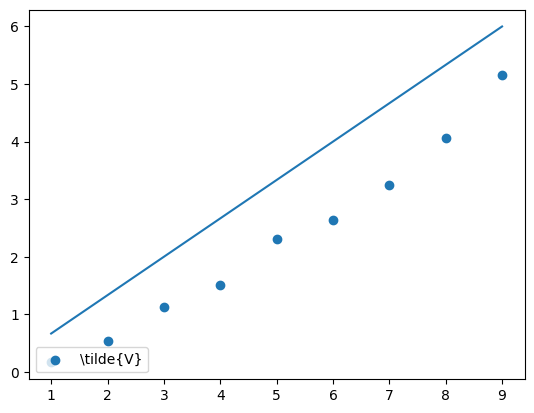

In [ ]:
plt.scatter(range(1,depth),Vmeas[1:]/(Kmeas[1:]**2),label=r'\tilde{V}')
plt.plot(range(1,depth),Vthy[1:]/(Kthy[1:]**2))
plt.legend(loc='lower left')

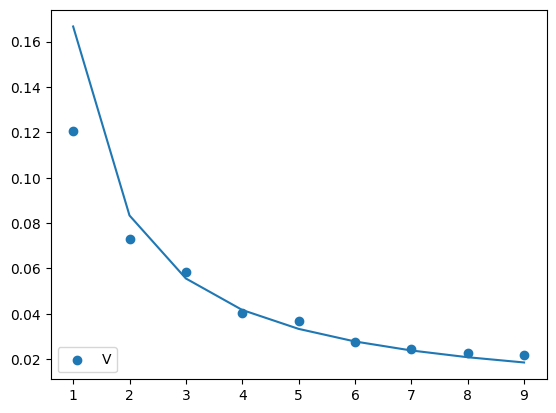

In [ ]:
plt.scatter(range(1,depth),Vmeas[1:],label=r'V')
plt.plot(range(1,depth),Vthy[1:])
plt.legend(loc='lower left')

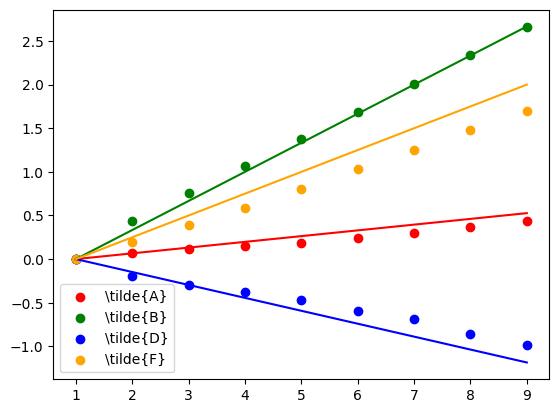

In [ ]:
plt.scatter(range(1,depth),Ameas[1:]/(Thetameas[1:]**2),label=r'\tilde{A}', color='red')
plt.plot(range(1,depth),Athy[1:]/(Thetathy[1:]**2) - Athy[1]/(Thetathy[1]**2), color = 'red')

plt.scatter(range(1,depth),Bmeas[1:]/(Thetameas[1:]**2),label=r'\tilde{B}', color = 'green')
plt.plot(range(1,depth),Bthy[1:]/(Thetathy[1:]**2)-Bthy[1]/(Thetathy[1]**2), color = 'green')

plt.scatter(range(1,depth),Dmeas[1:]/(Thetameas[1:]*Kmeas[1:]),label=r'\tilde{D}', color = 'blue')
plt.plot(range(1,depth),Dthy[1:]/(Thetathy[1:]*Kthy[1:])-Dthy[1]/(Thetathy[1]*Kthy[1]), color = 'blue')

plt.scatter(range(1,depth),Fmeas[1:]/(Thetameas[1:]*Kmeas[1:]),label=r'\tilde{F}', color = 'orange')
plt.plot(range(1,depth),Fthy[1:]/(Thetathy[1:]*Kthy[1:]) - Fthy[1]/(Thetathy[1]*Kthy[1]), color = 'orange')

plt.legend(loc='lower left')

In [ ]:
K11 = MeasureK(zs)
K22 = MeasureK(zs2)
K12 = MeasureK(zs2)
V1212 = MeasureV(zs,zs2)
Theta11 = MeasureTheta(Hhats)
Theta22 = MeasureTheta(Hhats2)
Amixed=MeasureA(Hhats,Hhats2)
Bmixed=MeasureB(Hhats,Hhats2)
Dmixed = MeasureD(zs,Hhats2)
Fmixed = MeasureF(zs,Hhats2)

print(K11)
print(K22)
print(K12)
print(V1212)
print(Theta11)
print(Theta22)
print(Amixed)
print(Bmixed)
print(Dmixed)
print(Fmixed)

[0.         0.36577588 0.22546865 0.1622106  0.1257387  0.10254128
 0.08593659 0.07448849 0.06505678 0.05777331]
[0.         1.1512945  0.423617   0.24733047 0.1741037  0.13325213
 0.10723121 0.0891371  0.0761104  0.06698277]
[0.         1.1512945  0.423617   0.24733047 0.1741037  0.13325213
 0.10723121 0.0891371  0.0761104  0.06698277]
[0.         0.24866813 0.01301107 0.00861925 0.00086363 0.00834222
 0.00396453 0.00461093 0.00381242 0.0009582 ]
[0.        1.3646724 1.6179883 1.6888206 1.7105653 1.7137562 1.7118493
 1.7084064 1.7023132 1.6983131]
[0.        2.1487112 1.8701617 1.7532105 1.6912948 1.651025  1.6252539
 1.607956  1.594876  1.5871366]
[0.0000000e+00 1.1652901e-09 1.5203753e-03 1.1761630e-02 2.1514345e-02
 4.3623567e-02 4.5849305e-02 9.8647773e-02 1.5634412e-01 1.9804871e-01]
[0.        0.        0.8535435 1.7496978 2.6219685 3.4672585 4.301201
 5.159635  6.000945  6.868644 ]
[ 0.          0.00035809 -0.01227392 -0.00827937  0.0056335   0.00312518
  0.00579044  0.00454136

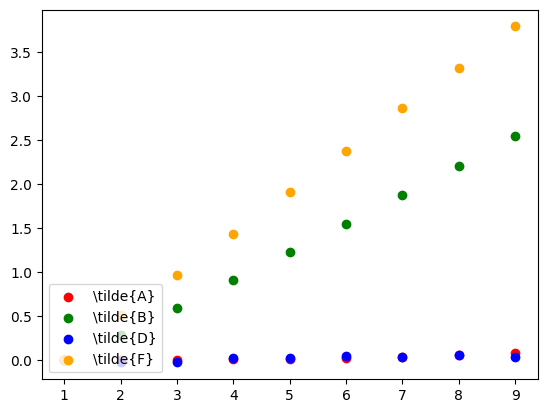

In [ ]:
plt.scatter(range(1,depth),Amixed[1:]/(Theta11[1:]*Theta22[1:]),label=r'\tilde{A}', color='red')

plt.scatter(range(1,depth),Bmixed[1:]/(Theta11[1:]*Theta22[1:]),label=r'\tilde{B}', color = 'green')

plt.scatter(range(1,depth),Dmixed[1:]/(K11[1:]*Theta22[1:]),label=r'\tilde{D}', color = 'blue')

plt.scatter(range(1,depth),Fmixed[1:]/(K11[1:]*Theta22[1:]),label=r'\tilde{F}', color = 'orange')

plt.legend(loc='lower left')

general multi-input: just make this a separate function, which should reduce to the single-input one when the two inputs are identical

In [ ]:
def CollectAllCorrelatorsTwoInput(data1,data2,NSample=1000,depth=10,width=30,inputwidth=30,init='Gaussian',actkey='tanh',
                                  lambdabtilde=1.0,lambdaWtilde=1.0,measurePQ=False,measureRSTU=False):

  Cb = 0 #all activations have Cb = 0 for criticality
  if actkey == 'tanh':
    if init =='Gaussian':
      CW = 1.0 + 2/(3*width) # NLO tuning
    else:
      CW = 1.0 # NLO tuning vanishes for orthogonal. Maybe do something clever for mixed inits?
    act = torch.tanh
  elif actkey == 'linear':
    CW = 1.0 # NLO tuning vanishes for scale-invariant
    act = lambda x: x
  elif actkey == 'ReLU':
    CW = 2.0 # NLO tuning vanishes for scale-invariant
    act = nn.ReLU()
  else:
    raise Exception("Unsupported choice of activation")

  if actkey == 'tanh':  #bias learning rate is an array that takes into account depth rescaling as appropriate
    lambdab_arr = lambdabtilde*np.array([1/max(l,1) for l in range(0,depth)])
  else:
    lambdab_arr = lambdabtilde*np.ones(depth)

  #initialize all arrays for measurement
  zs1=torch.zeros((NSample,depth, width)) #NOTE! zeroth entry is a DUMMY ENTRY ONLY because input width might be different
  zs2=torch.zeros((NSample,depth, width)) #NOTE! zeroth entry is a DUMMY ENTRY ONLY because input width might be different
  Hhats=torch.zeros((NSample,depth,width,width)) #NOTE! zeroth entry is a DUMMY ENTRY ONLY because input width might be different
  if measurePQ:
    dHhats = torch.zeros((NSample,depth,width,width,width)) #this is the limiting factor for memory!
  if measureRSTU:
    Rmeas1 = np.zeros(depth)
    Rmeas2 = np.zeros(depth)
    Rmeas3 = np.zeros(depth)
    Smeas = np.zeros(depth)
    Tmeas = np.zeros(depth)
    Umeas = np.zeros(depth)

  #auxiliary stuff we don't need to store
  sigmas=torch.zeros((depth,width))
  sigmaprs=torch.zeros((depth,width))
  sigmapprs=torch.zeros((depth,width))
  sigma3prs=torch.zeros((depth,width))

  for sample in range(NSample):
  #  if sample % 2 ==0: print(sample)
    mynet=MLP(activation=act,d=data.shape[0],n=width,nL=width,L=depth,cw=CW,weightinit=init)

    #initialize dictionary to call network layers
    layerdict_ = {}
    for i, fc in enumerate(mynet.fcs):
      layerdict_['layer%s' % i]  = fc #NOTE! layer fcl contains W^(l+1)
    _, zlist = mynet.forward(data)

    #get preactivations and activations/derivatives
    for l in range(1,depth): #leave everything at layer zero as zero
      zs[sample,l] = zlist[l]
      sigmas[l] = act(zs[sample,l])
      sigmaprs[l] = dact(actkey,zs[sample,l])
      if measurePQ:
        sigmapprs[l] = ddact(actkey,zs[sample,l])
      if measureRSTU:
        sigma3prs[l] = d3act(actkey,zs[sample,l])

    #initial conditions for H recursion at layer 1 (8.23)
    Hhats[sample,1] = torch.eye(width)*(lambdab_arr[1] + (lambdaWtilde/inputwidth)*torch.sum(data**2)) #note that normalization is by inputwidth
    #initial conditions for dH, ddH at layer 1 (it vanishes): automatically satisfied by initialization of dHhat and ddH_I, ddH_II arrays

    if measureRSTU:
      ddH_I = torch.zeros(width,width,width,width) #can compute ddNTK means on the fly so don't need NSample dimension
      ddH_II = torch.zeros(width,width,width,width)

    #compute H forward equation (8.12) and dH forward equation (11.24)
    for l in range(1,depth-1):
      Ws = layerdict_['layer%s' % l].weight
      Hhats[sample,l+1] = torch.eye(width)*(lambdab_arr[l+1] + (lambdaWtilde/width)*torch.sum(sigmas[l]**2)) + torch.einsum('aj,bk,j,k,jk->ab',Ws,Ws,sigmaprs[l],sigmaprs[l],Hhats[sample,l])

      if measurePQ:
      #index labeling for einsum: (i0 i1 i2) = (abc), (k0 k1 k2) = (klm)
        dHhats[sample,l+1] = (lambdaWtilde/width)*(torch.einsum('ab,cm,k,k,m,km->abc',torch.eye(width),Ws,sigmaprs[l],sigmas[l],sigmaprs[l],Hhats[sample,l]) +\
                                                  torch.einsum('ac,bl,k,l,k,kl->abc',torch.eye(width),Ws,sigmaprs[l],sigmas[l],sigmaprs[l],Hhats[sample,l])) +\
                          torch.einsum('ak,bl,cm,k,l,m,klm->abc',Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],dHhats[sample,l]) +\
                          torch.einsum('ak,bl,cm,k,l,m,kl,km->abc',Ws,Ws,Ws,sigmapprs[l],sigmaprs[l],sigmaprs[l],Hhats[sample,l],Hhats[sample,l])

      if measureRSTU:
      #still inside l loop
      # width*E[ddH_I] with 2 pairs of indices equal is R
      #index labeling for einsum: (i0 i1 i2 i3) = (abcd), (j0 j1 j2 j3) = (jklm), in first 3 terms use delta to eliminate a

        deltaterm = (lambdaWtilde/width)*(torch.einsum('ab,cl,dm,k,l,m,k,kl,km->abcd',torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],Hhats[sample,l],Hhats[sample,l]) +\
                                        torch.einsum('ab,cl,dm,k,l,m,k,klm->abcd',torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],dHhats[sample,l]) +\
                                        torch.einsum('ac,dm,bk,l,m,k,l,lm,lk->abcd',torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],Hhats[sample,l],Hhats[sample,l]) +\
                                        torch.einsum('ac,dm,bk,l,m,k,l,lmk->abcd',torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],dHhats[sample,l]) +\
                                        torch.einsum('ad,bk,cl,m,k,l,m,mk,ml->abcd',torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],Hhats[sample,l],Hhats[sample,l]) +\
                                        torch.einsum('ad,bk,cl,m,k,l,m,mkl->abcd',torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],dHhats[sample,l]))

        ddHterm = torch.einsum('aj,bk,cl,dm,k,l,m,j,jklm->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],ddH_I) +\
                  torch.einsum('aj,bk,cl,dm,k,l,m,j,jkl,jm->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],dHhats[sample,l],Hhats[sample,l]) +\
                  torch.einsum('aj,bk,cl,dm,k,l,m,j,jlm,jk->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],dHhats[sample,l],Hhats[sample,l]) +\
                  torch.einsum('aj,bk,cl,dm,k,l,m,j,jmk,jl->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],dHhats[sample,l],Hhats[sample,l]) +\
                  torch.einsum('aj,bk,cl,dm,k,l,m,j,jk,jl,jm->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigma3prs[l],Hhats[sample,l],Hhats[sample,l],Hhats[sample,l])
        ddH_I = deltaterm + ddHterm #this is now ddH_I at layer l+1

        #now compute expectations
        Rmeas1[l+1] += (1/NSample)*width/(width*(width-1)/2)*sum(ddH_I[i[0],i[0],i[1],i[1]] for i in combinations(range(width),2)).detach().numpy()
  #      Rmeas2[l+1] += (1/NSample)*width/(width*(width-1)/2)*sum(ddH_I[i[0],i[1],i[0],i[1]] for i in combinations(range(width),2)).detach().numpy() #only need these to check
  #      Rmeas3[l+1] += (1/NSample)*width/(width*(width-1)/2)*sum(ddH_I[i[0],i[1],i[1],i[0]] for i in combinations(range(width),2)).detach().numpy()  #only need these to check

      #index labeling for einsum: (i1 i2 i3 i4) = (abcd), (j1 j2 j3 j4) = (jklm)
        ddH_II = ((lambdaWtilde/width)**2)*torch.einsum('ac,bd,j,k,j,k,jk->abcd',torch.eye(width),torch.eye(width),sigmaprs[l],sigmaprs[l],sigmas[l],sigmas[l],Hhats[sample,l]) +\
                (lambdaWtilde/width)*(torch.einsum('ab,jk,cl,dm,j,k,l,m,jl,km->abcd',torch.eye(width),torch.eye(width),Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],Hhats[sample,l],Hhats[sample,l]) +\
                                      torch.einsum('ac,jl,bk,dm,l,m,j,k,kj,km->abcd',torch.eye(width),torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],Hhats[sample,l],Hhats[sample,l]) +\
                                      torch.einsum('ac,jl,bk,dm,l,m,j,k,kjm->abcd',torch.eye(width),torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],dHhats[sample,l]) +\
                                      torch.einsum('bd,km,aj,cl,m,l,k,j,jk,jl->abcd',torch.eye(width),torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],Hhats[sample,l],Hhats[sample,l]) +\
                                      torch.einsum('bd,km,aj,cl,m,l,k,j,jkl->abcd',torch.eye(width),torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],dHhats[sample,l])) +\
                torch.einsum('aj,bk,cl,dm,l,m,j,k,jklm->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],ddH_II) +\
                torch.einsum('aj,bk,cl,dm,l,m,j,k,jk,jl,km->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmapprs[l],sigmapprs[l],Hhats[sample,l],Hhats[sample,l],Hhats[sample,l]) +\
                torch.einsum('aj,bk,cl,dm,l,m,j,k,km,jkl->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],Hhats[sample,l],dHhats[sample,l]) +\
                torch.einsum('aj,bk,cl,dm,l,m,k,j,jl,kjm->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],Hhats[sample,l],dHhats[sample,l])
      #now compute expectations
        Smeas[l+1] += (1/NSample)*width/(width*(width-1)/2)*sum(ddH_II[i[0],i[0],i[1],i[1]] for i in combinations(range(width),2)).detach().numpy()
        Tmeas[l+1] += (1/NSample)*width/(width*(width-1)/2)*sum(ddH_II[i[0],i[1],i[0],i[1]] for i in combinations(range(width),2)).detach().numpy()
        Umeas[l+1] += (1/NSample)*width/(width*(width-1)/2)*sum(ddH_II[i[0],i[1],i[1],i[0]] for i in combinations(range(width),2)).detach().numpy()

  #  del mynet
    if measureRSTU:
      del deltaterm
      del ddHterm
      del ddH_I
      del ddH_II
      gc.collect()

  if measurePQ:
    if measureRSTU:
      RSTUDict={'R': Rmeas, 'S': Smeas, 'T': Tmeas, 'U': Umeas}
      return zs, Hhats, dHhats, RSTUDict
    else:
      return zs, Hhats, dHhats
  else:
    return zs, Hhats



Various testing things below

# Tests with network initialized to specific value

In [ ]:
mynet=MLP(activation=nn.ReLU(),d=10,n=10,nL=10,L=5,cw=2)
for i, fc in enumerate(mynet.fcs): print(i)

0
1
2
3
4
5


In [ ]:
mybiases = [torch.zeros(30) for _ in range(6)]
myweights = [torch.ones((30,30)) for _ in range(6)]
mynet=MLP(activation=nn.ReLU(),d=10,n=10,nL=10,L=5,cw=2,weightinit='custom', custombiases = mybiases, customweights = myweights)

for i, fc in enumerate(mynet.fcs):
  if i == 1:
    print(fc.weight.shape)

torch.Size([30, 30])


In [ ]:
HannahWeights0 = np.array([[[-0.10511495,  0.2731756 ,  0.16313358, -0.20853649,
          0.29507026,  0.3284962 , -0.16663392,  0.02228089,
          0.05395906, -0.01432054],
        [ 0.03320023,  0.23438993, -0.45054153,  0.02837742,
          0.3046813 ,  0.2807762 , -0.07241964, -0.11109789,
          0.35185316, -0.25289047],
        [-0.15982842,  0.18784158,  0.6966447 , -0.19391881,
          0.2516027 , -0.02459229,  0.2527585 ,  0.41359594,
          0.19657248, -0.20072877],
        [-0.13587359, -0.05853851, -0.11978576,  0.11882971,
         -0.14772382, -0.40896067,  0.10096776,  0.7581863 ,
          0.20698468, -0.11152217],
        [ 0.01973841,  0.24538559,  0.15582913,  0.57207775,
         -0.45452693,  0.2678249 , -0.19784786,  0.48706374,
          0.29586607, -0.24989915],
        [-0.22451393,  0.4592819 ,  0.46478486, -0.20996508,
         -0.10575095, -0.29155612,  0.08631505, -0.01303038,
          0.36158898, -0.01306659],
        [ 0.34605289, -0.24182425, -0.12569313, -0.13674274,
          0.30896074,  0.3045286 ,  0.10840249, -0.30866796,
         -0.12946379,  0.07322646],
        [ 0.7083253 ,  0.2941746 ,  0.31492338,  0.265813  ,
         -0.11820043,  0.21453977, -0.6059211 , -0.19761051,
         -0.23001485,  0.1846916 ],
        [ 0.03471178,  0.5701528 ,  0.23166889, -0.06504353,
         -0.0613872 ,  0.6145765 , -0.08700365,  0.29470387,
         -0.12861037,  0.27897918],
        [ 0.03237559, -0.44294575, -0.46736407, -0.04176963,
         -0.42519185, -0.6656779 , -0.08524457, -0.13524659,
          0.07830801,  0.03334095]],

       [[ 0.25223422, -0.36875412,  0.27879426,  0.06555589,
         -0.4879182 , -0.32412294, -0.366641  ,  0.27655655,
          0.37798288, -0.02787758],
        [ 0.22379495,  0.11905142,  0.30282798,  0.19826649,
         -0.351624  , -0.2027192 , -0.02901677,  0.04551022,
         -0.02655784,  0.04995441],
        [-0.19782004, -0.13707542, -0.13645947, -0.3166789 ,
         -0.8092719 ,  0.13999681,  0.15312639,  0.44201273,
          0.47540724,  0.26158828],
        [ 0.36147696,  0.39800674,  0.16571729,  0.376874  ,
         -0.56942934, -0.14302021, -0.48985127,  0.10347954,
         -0.3280575 , -0.08517969],
        [-0.357293  , -0.38672677,  0.04437907,  0.2445966 ,
         -0.25434163, -0.21144442,  0.38893428,  0.20343634,
         -0.20231195, -0.11317167],
        [ 0.22689599,  0.18886462, -0.06605589,  0.07636483,
         -0.05886213, -0.14776812,  0.25858048, -0.39303562,
         -0.44478676,  0.22093418],
        [ 0.24205688, -0.2162584 , -0.14773907,  0.2000312 ,
          0.19129083,  0.20384638,  0.13266008,  0.04888383,
         -0.22807337, -0.39893037],
        [-0.6288413 ,  0.0442904 , -0.4009296 ,  0.5871881 ,
          0.3184394 ,  0.53007233, -0.18720485, -0.5912883 ,
         -0.055675  , -0.12108852],
        [ 0.14122804,  0.232121  , -0.04846784,  0.0674846 ,
         -0.3945577 ,  0.02288637,  0.0483439 , -0.30612308,
          0.04521633,  0.02577228],
        [-0.21825278,  0.14872625,  0.15101053, -0.55375224,
          0.72758   ,  0.27440265, -0.3349091 ,  0.05306192,
          0.03865828, -0.35710686]],

       [[ 0.06030054,  0.05577037, -0.19060336, -0.63789624,
          0.22287087, -0.11463532, -0.00401992,  0.01725737,
          0.05967684,  0.2892703 ],
        [ 0.27711546, -0.4849554 ,  0.10166821, -0.40921366,
          0.30818555, -0.07633942, -0.02056959,  0.02876144,
         -0.5128113 , -0.12553318],
        [ 0.3471684 ,  0.36400944,  0.2838301 , -0.09905159,
         -0.01920666,  0.05312399, -0.32379153,  0.0349914 ,
         -0.35134047,  0.02207016],
        [ 0.4317887 , -0.18177283, -0.14047673,  0.30301365,
         -0.5644622 ,  0.56991136, -0.02238466, -0.646386  ,
          0.03414813,  0.0033076 ],
        [ 0.39889762, -0.389368  ,  0.10612588, -0.04938071,
          0.14328152, -0.36029607,  0.33400092,  0.04931294,
         -0.22491273,  0.2203649 ],
        [-0.3489433 ,  0.07550818,  0.37694514,  0.24784483,
          0.12188232, -0.00142459,  0.42119676, -0.45958614,
         -0.25677162,  0.09712364],
        [ 0.17570004,  0.41393736,  0.45463264, -0.41117147,
          0.4127558 ,  0.10606068,  0.5005839 ,  0.3741471 ,
          0.1527385 ,  0.1683014 ],
        [-0.47901857,  0.1096984 , -0.30894276,  0.037101  ,
         -0.28004524, -0.384118  , -0.03433898, -0.4621916 ,
          0.03222803,  0.26429686],
        [ 0.30146566, -0.1948367 ,  0.7041734 ,  0.33163965,
          0.24992827, -0.03112125,  0.05038082,  0.10080177,
         -0.5488839 , -0.13596989],
        [-0.3415829 ,  0.15183167,  0.23140836, -0.40850875,
         -0.3423185 , -0.14183976,  0.07552311,  0.32838306,
          0.32239953, -0.04764025]],

       [[ 0.08770594,  0.07024522, -0.22339031,  0.42030904,
          0.2720374 , -0.49374342,  0.08867216,  0.4472019 ,
         -0.04662995, -0.18836176],
        [-0.0925663 , -0.01516291, -0.5539904 , -0.01320591,
         -0.03304632,  0.346112  ,  0.47358382,  0.07565016,
          0.36026496,  0.17582157],
        [ 0.28767315,  0.34657207, -0.06846831,  0.6512522 ,
         -0.34851143, -0.5357154 , -0.5260077 , -0.29695004,
         -0.03837488, -0.5540763 ],
        [ 0.2445664 , -0.1566674 , -0.34479782, -0.02762346,
         -0.18097672, -0.49263278, -0.54588985, -0.03989764,
         -0.07561245,  0.10671444],
        [ 0.11113348,  1.1057787 ,  0.20267002, -0.21735585,
         -0.44212762,  0.17751828, -0.13342346, -0.07945013,
         -0.30977094,  0.0755721 ],
        [ 0.12866847,  0.18431   , -0.03198522,  0.24327472,
         -0.44005802, -0.5214999 , -0.6957018 , -0.2857864 ,
         -0.3317453 , -0.08671753],
        [-0.13568532,  0.22551987, -0.5683137 ,  0.3742571 ,
         -0.044749  , -0.18123728, -0.18204492,  0.04989436,
         -0.24903513,  0.05536607],
        [-0.1639678 , -0.3935764 , -0.36254907,  0.33637857,
         -0.29477262, -0.03725522,  0.05685831, -0.0836356 ,
          0.27009475,  0.0200796 ],
        [-0.31221586, -0.6424678 , -0.47718772, -0.07193278,
          0.2622277 ,  0.09181307, -0.20054252, -0.10025508,
         -0.52103424,  0.23049764],
        [-0.1444693 , -0.3518068 ,  0.03052701, -0.22362706,
          0.16956957,  0.31434458,  0.57791054, -0.02526635,
         -0.19918366,  0.6409524 ]]])

HannahWeights1 = np.array([[[ 1.48679271e-01, -3.64224203e-02,  3.36979479e-01,
          8.95887837e-02, -1.91782013e-01,  3.46941561e-01,
         -1.98722035e-01,  2.09092528e-01, -1.11984901e-01,
         -1.89233452e-01],
        [ 7.69881681e-02,  4.63042825e-01,  8.65032375e-02,
         -4.79488485e-02, -7.04127103e-02,  5.73741719e-02,
          2.43325345e-02, -3.24315995e-01, -2.81872332e-01,
         -3.64643186e-01],
        [ 1.77302435e-01,  4.42029685e-02,  6.17626682e-02,
         -1.34598330e-01, -1.69532329e-01, -2.82736778e-01,
         -5.07592969e-02,  3.43190670e-01,  4.55482230e-02,
          3.46413195e-01],
        [ 1.29725352e-01, -2.22389579e-01,  4.25511487e-02,
          7.57262930e-02, -5.19696474e-01, -2.61415243e-01,
         -1.60858318e-01, -2.59968847e-01, -1.94386497e-01,
         -3.76062244e-01],
        [ 2.09796242e-02,  8.93977582e-02, -2.35552683e-01,
         -3.40593345e-02,  1.45043716e-01,  1.41032797e-03,
         -1.44956425e-01,  1.65554181e-01,  1.93036333e-01,
         -4.61456180e-01],
        [-4.56070334e-01, -1.45721972e-01,  3.12066674e-01,
          2.44494721e-01,  2.81341732e-01,  2.46548638e-01,
          6.01541281e-01, -6.95505142e-01, -2.08603516e-01,
          5.65003633e-01],
        [-3.06392401e-01,  5.94993532e-01,  1.73599526e-01,
         -8.89321566e-02, -3.57588053e-01, -4.67413753e-01,
          3.25164884e-01,  2.05874860e-01, -1.35577202e-01,
          1.15618758e-01],
        [ 8.09913427e-02,  9.63557959e-02, -1.77522272e-01,
          2.19206318e-01,  1.84164971e-01, -4.15901035e-01,
          1.49657786e-01, -9.62380245e-02,  1.22314848e-01,
          5.62524557e-01],
        [ 4.99787718e-01,  1.27177149e-01, -6.21755011e-02,
          2.85577141e-02,  6.22093081e-01,  6.88582361e-01,
          3.87675434e-01, -1.17584225e-02,  3.31527479e-02,
          6.23720661e-02],
        [-1.16767950e-01, -6.36070609e-01, -5.75419605e-01,
          5.60686350e-01,  2.21956417e-01, -2.93342620e-01,
          2.00210605e-02, -5.95761538e-01, -7.17048764e-01,
          2.36496910e-01]],

       [[-2.23182186e-01,  3.62028241e-01,  3.79269779e-01,
         -1.79734334e-01,  3.71607602e-01,  2.28365064e-01,
         -1.84628367e-01,  5.40792346e-01,  2.77567785e-02,
          1.14569679e-01],
        [-1.22958392e-01,  5.98047003e-02, -4.15168792e-01,
         -2.93682497e-02, -3.22839916e-01,  1.21669643e-01,
         -1.18642695e-01,  3.06634000e-03,  4.08791691e-01,
         -2.85440832e-01],
        [-4.20209736e-01,  4.34167802e-01,  7.14896768e-02,
          7.52717018e-01,  2.43204728e-01, -5.55859625e-01,
          1.25258826e-02,  9.84044015e-01,  3.81857723e-01,
          1.28016025e-01],
        [-6.16592646e-01,  4.87263560e-01, -2.86262214e-01,
         -3.47447038e-01, -2.68280119e-01, -4.27762046e-02,
          2.48965532e-01, -8.65766704e-02,  4.09743637e-01,
         -2.67952055e-01],
        [-4.32805330e-01,  5.10312021e-01,  3.65920335e-01,
         -1.32663071e-01, -3.34405825e-02, -1.12491036e-02,
          8.07280838e-03,  1.54567704e-01, -3.97907615e-01,
          3.04640979e-01],
        [-1.52550116e-01,  5.47359049e-01,  2.41651222e-01,
         -1.75821051e-01, -3.97594184e-01, -3.71220082e-01,
         -1.00609727e-01,  3.49945091e-02,  1.70219153e-01,
         -9.92537513e-02],
        [-1.70581147e-01, -4.20867890e-01, -4.37673926e-02,
         -4.31219518e-01,  1.24796294e-01, -3.88213813e-01,
         -3.31943691e-01,  4.70432281e-01,  2.36245543e-01,
          5.43365836e-01],
        [-3.21572244e-01, -8.88303220e-02,  1.66901678e-01,
          1.63511381e-01,  3.25653166e-01,  3.42486411e-01,
         -4.09591079e-01, -6.77305639e-01,  2.81461507e-01,
          6.70868009e-02],
        [-2.15983078e-01,  1.28974184e-01, -3.64690691e-01,
         -1.58403277e-01, -8.58767796e-03,  7.85657391e-02,
          9.44000930e-02, -7.67859876e-01, -4.58567180e-02,
         -9.84982923e-02],
        [ 2.73934286e-02,  7.72025436e-02,  1.10552274e-01,
         -1.12798162e-01, -7.84763247e-02, -1.29186973e-01,
         -6.84558153e-01, -1.11891739e-01,  9.82927606e-02,
         -1.57872245e-01]],

       [[ 3.45993817e-01,  1.14892662e-01,  4.90961000e-02,
          1.62063807e-01,  3.90696377e-01,  1.78473681e-01,
         -2.93802917e-01, -5.61977103e-02,  3.35497975e-01,
         -1.05284095e-01],
        [ 2.34384120e-01, -3.06940913e-01,  2.16572985e-01,
         -1.31416902e-01, -1.45967752e-02, -2.92743146e-01,
         -2.25171968e-01,  6.44652486e-01,  3.53000313e-01,
         -3.08562696e-01],
        [ 8.30343887e-02, -1.79545075e-01, -6.32914484e-01,
         -6.88682318e-01,  1.44149691e-01,  2.79310554e-01,
          2.35615999e-01, -2.80449033e-01,  3.97503823e-01,
          4.08961266e-01],
        [ 3.45616579e-01,  4.98079598e-01, -1.05719976e-01,
         -5.06006405e-02, -1.95163205e-01, -1.91967815e-01,
          3.00068170e-01, -2.82448769e-01, -4.88839447e-01,
         -4.68110770e-01],
        [ 1.29214317e-01, -5.04289091e-01,  3.67436260e-01,
          1.57276243e-01, -3.01795900e-01,  1.19112767e-02,
         -2.42425784e-01,  2.76080668e-01,  1.64770320e-01,
          2.64273047e-01],
        [ 4.59662169e-01,  2.02046335e-01,  4.44865942e-01,
         -2.94527441e-01, -1.17152341e-01,  9.34676901e-02,
         -3.51334691e-01,  4.84825760e-01,  1.31410554e-01,
         -2.38919184e-01],
        [-2.00081870e-01, -6.18656341e-04, -1.14280410e-01,
          3.86276186e-01, -1.61807060e-01, -2.89683938e-01,
          1.51568716e-02,  2.97610462e-01,  2.52506077e-01,
         -4.27870214e-01],
        [ 6.54129207e-01, -1.80655614e-01,  4.36898172e-01,
         -1.87945947e-01,  3.57408732e-01, -4.59264904e-01,
         -2.28349082e-02, -2.00924262e-01, -5.93978524e-01,
          1.92772761e-01],
        [-9.67286155e-02,  3.66978794e-01, -3.27638164e-02,
          5.50877452e-01, -1.12005107e-01,  3.42366397e-02,
          3.02897394e-02, -8.37527439e-02, -7.81202391e-02,
         -2.44329467e-01],
        [ 4.91299659e-01, -9.07758996e-03, -5.00938334e-02,
          3.87728512e-01, -2.41983578e-01,  8.80430564e-02,
         -2.98540980e-01,  2.68985108e-02, -1.54022112e-01,
         -8.38089287e-02]],

       [[ 7.71912694e-01,  2.90996939e-01, -2.33471498e-01,
         -8.72197226e-02, -1.14148699e-01, -2.55326569e-01,
         -3.85582298e-01, -1.08558960e-01,  1.59842893e-01,
         -3.77941132e-01],
        [-4.30915179e-03,  4.25721914e-01, -1.25884339e-01,
          3.66805166e-01, -7.63127267e-01, -1.65600091e-01,
          3.43274891e-01, -6.44910783e-02, -1.75824404e-01,
         -2.40782201e-01],
        [-2.38727495e-01,  1.33929521e-01,  2.77397066e-01,
          6.15849733e-01, -6.02507472e-01, -1.15436397e-01,
          2.01846510e-01,  3.98995638e-01,  1.74711086e-02,
         -1.23013809e-01],
        [ 2.69742906e-01, -1.26258984e-01,  2.99439758e-01,
          1.21401444e-01,  3.97034109e-01, -2.84989208e-01,
         -1.57547623e-01,  3.28247726e-01,  3.03037971e-01,
         -4.01510984e-01],
        [-8.23715329e-02, -5.53941764e-02, -9.23459232e-02,
         -4.89431053e-01,  2.63676289e-02, -3.21753472e-01,
         -7.64091462e-02, -3.36594254e-01,  2.75888890e-02,
          4.02793884e-01],
        [ 2.37775236e-01, -2.06702486e-01,  9.63009372e-02,
         -1.11980602e-01,  4.59272414e-02, -4.42508876e-01,
          7.21042529e-02,  2.46391952e-01,  1.35682493e-01,
         -1.19808733e-01],
        [-3.23544532e-01,  3.71031731e-01, -4.01947558e-01,
         -5.34237921e-01,  4.99029309e-01, -4.14038777e-01,
         -6.39245272e-01,  6.59365833e-01,  2.60955960e-01,
          3.85533005e-01],
        [-1.72001824e-01,  3.11186999e-01, -2.41782293e-01,
          3.26003581e-01,  4.87130553e-01,  7.47878373e-01,
          5.42394102e-01, -2.19946444e-01,  8.53964090e-02,
         -7.44697750e-02],
        [ 5.02225310e-02,  2.60571539e-01,  7.61528790e-01,
         -5.64140320e-01, -1.13439716e-01,  6.14782155e-01,
          3.33698303e-01,  1.68626547e-01, -9.84842032e-02,
         -9.21275988e-02],
        [-2.68706501e-01,  1.77389756e-01, -1.93038762e-01,
         -4.21561867e-01,  4.52586353e-01,  2.13393807e-01,
         -3.90750542e-02, -1.03144810e-01,  6.19902089e-02,
          1.05878353e-01]]])

In [ ]:
#network architecture
depth = 3
width = 10

#set activation here
actkey = 'tanh'
init = 'custom'

#set learning rates here
lambdabtilde = 1.0
lambdaWtilde = 1.0

measurePQ = False
measureRSTU = False

Cb = 0 #all activations have Cb = 0 for criticality
if actkey == 'tanh':
  if init =='Gaussian':
    CW = 1.0 + 2/(3*width) # NLO tuning
  else:
    CW = 1.0 # NLO tuning vanishes for orthogonal. Maybe do something clever for mixed inits?
  act = torch.tanh
elif actkey == 'linear':
  CW = 1.0 # NLO tuning vanishes for scale-invariant
  act = lambda x: x
elif actkey == 'ReLU':
  CW = 2.0 # NLO tuning vanishes for scale-invariant
  act = nn.ReLU()
else:
  raise Exception("Unsupported choice of activation")


if actkey == 'tanh':  #bias learning rate is an array that takes into account depth rescaling as appropriate
  lambdab_arr = lambdabtilde*np.array([1/max(l,1) for l in range(0,depth)])
else:
  lambdab_arr = lambdabtilde*np.ones(depth)

#random input data (single-input)
data = torch.ones(width)

#kernel fixed point for ReLU
Kstar = 2*np.mean(data.detach().numpy()**2)

NSample = 2

#initialize all arrays for measurement
zs=torch.zeros((NSample,depth, width))
Ghats=torch.zeros((NSample,depth)) #note Ghat has NO neural indices since by assumption it is diagonal
Hhats=torch.zeros((NSample,depth,width,width))
if measurePQ:
  dHhats = torch.zeros((NSample,depth,width,width,width)) #this gets pretty big, best to keep width fairly small...

if measureRSTU:
#can compute ddNTK means on the fly so only need to store smaller arrays
  Rmeas = torch.zeros(depth)
  Smeas = torch.zeros(depth)
  Tmeas = torch.zeros(depth)
  Umeas = torch.zeros(depth)

#auxiliary stuff we don't need to store
sigmas=torch.zeros((depth,width))
sigmaprs=torch.zeros((depth,width))
sigmapprs=torch.zeros((depth,width))

for sample in range(NSample):
  binits = [torch.zeros(10) for _ in range(depth+1)]
  if sample == 0:
    WInits = torch.tensor(HannahWeights0,dtype=torch.float32)
  if sample == 1:
    WInits = torch.tensor(HannahWeights1,dtype=torch.float32)
  mynet=MLP(activation=act,d=data.shape[0],n=width,nL=width,L=depth,cw=CW,weightinit=init,custombiases = binits, customweights = WInits)

  #initialize dictionary to call network layers
  layerdict_ = {}
  for i, fc in enumerate(mynet.fcs):
    layerdict_['layer%s' % i]  = fc #NOTE! layer fcl contains W^(l+1)
  _, zlist = mynet.forward(data)

  #get preactivations and activations/derivatives
  zs[sample,0] = zlist[0]
  for l in range(1,depth):
    zs[sample,l] = zlist[l]
    sigmas[l] = act(zs[sample,l])
    sigmaprs[l] = dact(actkey,zs[sample,l])
    sigmapprs[l] = ddact(actkey,zs[sample,l])

  #compute metric
  Ghats[sample,1] = Cb + (CW/width)*torch.sum(data**2)
  for l in range(1,depth-1):
    Ghats[sample,l+1] = Cb + (CW/width)*torch.sum(sigmas[l]**2) # (4.70)

  #initial conditions for H recursion at layer 1 (8.23)
  Hhats[sample,1] = torch.eye(width)*(lambdab_arr[1] + (lambdaWtilde/width)*torch.sum(data**2))

  #compute H forward equation (8.12) and dH forward equation (11.24)
  for l in range(1,depth-1):
    Ws = layerdict_['layer%s' % l].weight
    Hhats[sample,l+1] = torch.eye(width)*(lambdab_arr[l] + (lambdaWtilde/width)*torch.sum(sigmas[l]**2)) + torch.einsum('aj,bk,j,k,jk->ab',Ws,Ws,sigmaprs[l],sigmaprs[l],Hhats[sample,l])
    if measurePQ:
      deltaterm1 = (lambdaWtilde/width)*torch.kron(torch.eye(width),torch.einsum('am,k,k,m,km->a',Ws,sigmaprs[l],sigmas[l],sigmaprs[l],Hhats[sample,l]))
      deltaterm1 = deltaterm1.reshape((width,width,width))
      deltaterm2 = (lambdaWtilde/width)*torch.kron(torch.eye(width),torch.einsum('bl,k,l,k,kl->b',Ws,sigmaprs[l],sigmaprs[l],sigmas[l],Hhats[sample,l]))
      deltaterm2 = torch.swapaxes(deltaterm2.reshape((width,width,width)),1,2)
      dHhats[sample,l+1] = torch.einsum('ak,bl,cm,k,l,m,klm->abc',Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],dHhats[sample,l]) + \
                        torch.einsum('ak,bl,cm,k,l,m,kl,km->abc',Ws,Ws,Ws,sigmapprs[l],sigmaprs[l],sigmaprs[l],Hhats[sample,l],Hhats[sample,l]) + deltaterm1 + deltaterm2

    if measureRSTU:
    #still inside l loop, this is just schematic for now
    # width*E[ddH_I] with 2 pairs of indices equal is R
    #index labeling for einsum: (i0 i1 i2 i3) = (abcd), (j0 j1 j2 j3) = (jklm), in first 3 terms use delta to eliminate a
      delta01 = (lambdaWtilde/width)*torch.kron(torch.eye(width), torch.einsum('cl,dm,k,l,m,k,kl,km->cd',Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],Hhats[sample,l],Hhats[sample,l]) + \
      torch.einsum('cl,dm,k,l,m,k,klm->cd',Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],dHhats[sample,l]))
      delta01 = delta01.reshape((width,width,width,width))


In [ ]:
Ghats.detach().numpy()

array([[0.        , 1.        , 0.44673815],
       [0.        , 1.        , 0.4028719 ]], dtype=float32)

In [ ]:
MeasureG(Ghats)

array([0.        , 1.        , 0.42480505], dtype=float32)

In [ ]:
np.mean(.5*((zs[0,2]**2).detach().numpy() + (zs[1,2]**2).detach().numpy()))

0.23253278

non-square networks

In [ ]:
mynetrect=MLP(activation=act,d=2,n=5,nL=5,L=1,cw=2)
mynetrect.fc0.weight.shape

torch.Size([5, 2])

test various possibilities for orthogonal inits

In [ ]:
mynet_orth=MLP(activation=nn.ReLU(),d=5,n=5,nL=5,L=2,cw=1,weightinit='orthogonal')
mynet_gaus=MLP(activation=nn.ReLU(),d=5,n=5,nL=5,L=2,cw=1,weightinit='Gaussian')
mynet_linear=MLP(activation='linear',d=5,n=5,nL=5,L=2,cw=1,weightinit='orthogonal')

In [ ]:
print(mynet_gaus.fc2.weight.dtype)
print(mynet_orth.fc2.weight.dtype)

In [ ]:
m = mynet_orth.fc2.weight
torch.matmul(m,m.t()) #note that d32 will have 1e-8 errors in orthogonal inits, d64 will be 1e-16 but there seems to be a problem with this data type

In [ ]:
#ortho_group naturally has d64 data type
x = ortho_group.rvs(5)
print(x)
print(x.transpose())
print(np.matmul(x,x.transpose()))

In [ ]:
mynet_mixed=MLP(activation=nn.ReLU(),d=5,n=5,nL=5,L=2,cw=1,weightinit='mixed0')
m0 = mynet_mixed.fc0.weight
print(torch.matmul(m0,m0.t()))
m1 = mynet_mixed.fc1.weight
print(torch.matmul(m1,m1.t()))